**Importando bibliotecas**

In [70]:
import pandas as pd
import folium
import matplotlib.pyplot as plt
import bar_chart_race as bcr
from sklearn import svm
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

**Função para verificar a porcentagem de cada Região**

In [71]:
def plot_porcentagens_cidades(df_cidades):
    total_casos = df_cidades['Total'].sum()
    
    porcentagens = (df_cidades['Total'] / total_casos) * 100
    
    plt.figure(figsize=(15, 12))
    
    bars = plt.bar(df_cidades['Região de Saúde'], porcentagens, color='skyblue', width=0.6, align='center')
    
    plt.xlabel('Região de Saúde')
    plt.ylabel('Porcentagem de Casos (%)')
    plt.title('Porcentagem de casos de Dengue por região administrativa entre 2019 e 2023')
    plt.xticks(rotation=45, ha='right')
    
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.1f}%', ha='center', va='bottom')
    
    plt.tight_layout()
    plt.show()

**Função para verificar a porcentagem de cada Região**

In [72]:
def plot_porcentagens_regioes(df_regiao):
    total_casos = df_regiao['Total'].sum()
    
    porcentagens = (df_regiao['Total'] / total_casos) * 100
    
    plt.figure(figsize=(10, 10))
    
    
    plt.pie(porcentagens, labels=df_regiao['Região de Saúde'], autopct='%1.1f%%', startangle=140)
    plt.title('Porcentagem de casos de Dengue por cidade entre 2019 a 2023')
    plt.axis('equal') 
    plt.show()


**Função para verificar a cidade com mais casos**

In [73]:
def cidade_com_mais_casos(df_cidade):
    if 'Total' in df_cidade.columns:
        df_cidade.drop(columns=['Total'], inplace=True)

    df_cidade['Total'] = df_cidade.iloc[:, 1:].sum(axis=1)

    cidade_mais_casos = df_cidade.loc[df_cidade['Total'].idxmax()]

    quantidade_casos = cidade_mais_casos['Total']
    total_casos = df_cidade['Total'].sum()
    porcentagem_casos = (quantidade_casos / total_casos) * 100

    print("Região de Saúde com mais casos de dengue:")
    print(cidade_mais_casos['Região de Saúde'])
    print("Quantidade total de casos de dengue nesta região:")
    print(quantidade_casos)
    print("Porcentagem de casos em relação ao total:")
    print("{:.2f}%".format(porcentagem_casos))


**Função para verificar a região com mais casos**

In [74]:
def regiao_com_mais_casos(df_regiao):
    if 'Total' in df_regiao.columns:
        df_regiao.drop(columns=['Total'], inplace=True)

    df_regiao['Total'] = df_regiao.iloc[:, 1:].sum(axis=1)

    regiao_mais_casos = df_regiao.loc[df_regiao['Total'].idxmax()]

    quantidade_casos = regiao_mais_casos['Total']

    print("Região de Saúde com mais casos de dengue:")
    print(regiao_mais_casos['Região de Saúde'])
    print("Quantidade total de casos de dengue nesta região:")
    print(quantidade_casos)

**Função para plotar cada uma das regiões administrativas**

In [75]:
def plotar_casos_dengue_por_regiao(dados):
    anos = [2019, 2020, 2021, 2022, 2023]
    for regiao_saude in dados['Região de Saúde'].unique():
        dados_regiao = dados[dados['Região de Saúde'] == regiao_saude]
        
        casos_por_ano = [dados_regiao[ano].sum() for ano in anos]
        
        plt.figure(figsize=(10, 6))
        plt.plot(anos, casos_por_ano, marker='o')
        plt.title(f"Casos de Dengue por Ano na Região de Saúde: {regiao_saude}")
        plt.xlabel("Ano")
        plt.ylabel("Casos de Dengue")
        plt.xticks(anos)
        plt.grid(True)
        plt.show()

   **Criando um função de  mapa de calor com os casos de Dengue em subdistritos,
    utilizando dados de um arquivo Excel e um arquivo GeoJSON.**

In [76]:
def criar_mapa_dengue(nome_arquivo_geojson, nome_arquivo_excel):
    # Carregar dados de casos de Dengue
    casos = pd.read_excel(nome_arquivo_excel)
    casos = casos.dropna(subset=["subdistrito"])
    casos["casos"] = casos[[2019, 2020, 2021, 2022, 2023]].sum(axis=1)
    
    # Criar o mapa
    mapa = folium.Map([-15.7801, -47.9292], zoom_start=9.7)
    
    # Adicionar o mapa de coropléticos
    folium.Choropleth(
        geo_data=nome_arquivo_geojson,
        data=casos,
        columns=["subdistrito", "casos"],
        key_on="feature.properties.id",
        fill_color="GnBu",
        fill_opacity=0.9,
        line_opacity=0.5,
        legend_name="DENGUE",
        nan_fill_color="white",
        name="Casos de Dengue"
    ).add_to(mapa)
    
    # Estilo para os elementos não destacados
    estilo = lambda x: {
        "fillColor": "white",
        "color": "black",
        "fillOpacity": 0.001,
        "weight": 0.001
    }

    # Estilo para os elementos destacados
    estilo_destaque = lambda x: {
        "fillColor": "darkblue",
        "color": "black",
        "fillOpacity": 0.5,
        "weight": 1
    }

    # Adicionando o GeoJson para Cidades
    highlight = folium.features.GeoJson(
        data=nome_arquivo_geojson,
        style_function=estilo,
        highlight_function=estilo_destaque,
        name="Cidades"
    )

    # Adicionando caixa de texto para Cidades
    folium.features.GeoJsonTooltip(
        fields=["name", "id"],
        aliases=["Subdistrito:", "Casos"],
        labels=True,
        style="background-color: white; color: black; font-family: arial; font-size: 16px; padding: 10px;"
    ).add_to(highlight)

    # Adicionando o destaque ao mapa
    mapa.add_child(highlight)

    # Adicionando o controle de camadas
    folium.LayerControl().add_to(mapa)

    # Retornar o mapa
    return mapa

**A função `analise_com_svm(dados)` realiza uma análise de regressão SVM para prever o número de casos de dengue em cada região de saúde. Ela recebe um DataFrame `dados` contendo os dados das cidades (linhas) e os anos (colunas) e gera gráficos comparando os dados reais com as previsões para os próximos 5 anos.**


In [94]:
def analise_com_svm(dados):
    regioes_saude = dados['Região de Saúde'].unique()

    for regiao_saude in regioes_saude:
        dados_regiao = dados[dados['Região de Saúde'] == regiao_saude]

        anos = np.array([2019, 2020, 2021, 2022, 2023])  # Anos
        casos = dados_regiao.values[0][1:]  # Número de casos de dengue para a região de saúde

        # Reshape dos dados para atender ao formato necessário do sklearn
        anos = anos.reshape(-1, 1)

        # Criando o modelo SVM para regressão
        modelo = svm.SVR(kernel='linear')

        # Treinando o modelo
        modelo.fit(anos, casos)

        # Fazendo previsões para os próximos 5 anos
        anos_pred = np.array([2024, 2025, 2026, 2027, 2028]).reshape(-1, 1)
        casos_pred = modelo.predict(anos_pred)

        # Plotando os resultados
        plt.figure(figsize=(12, 6))

        plt.subplot(1, 2, 1)
        plt.scatter(anos, casos, color='black', label='Dados reais')
        plt.plot(anos_pred, casos_pred, color='blue', linewidth=3, label='Predição SVM')
        plt.xlabel('Ano')
        plt.ylabel('Casos de Dengue')
        plt.title(f'Análise de Regressão para {regiao_saude}')
        plt.legend()

        # Exibindo as previsões para os próximos 5 anos
        print(f"Previsões para os próximos 5 anos para {regiao_saude}:")
        for ano, casos_previstos in zip(anos_pred, casos_pred):
            print("Ano:", int(ano), " - Casos previstos:", casos_previstos)

        # Gráfico de barras comparando casos reais e previstos
        plt.subplot(1, 2, 2)
        anos_totais = np.concatenate((anos, anos_pred), axis=None)
        casos_totais = np.concatenate((casos, casos_pred), axis=None)
        bars = plt.bar(anos_totais, casos_totais, color=['black'] * len(anos) + ['blue'] * len(anos_pred))
        plt.xlabel('Ano')
        plt.ylabel('Casos de Dengue')
        plt.title('Comparação de casos reais e previstos')
        plt.xticks(anos_totais)

        # Adicionando o número de casos em cima de cada barra
        for bar, caso in zip(bars, casos_totais):
            plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), int(caso),
                     ha='center', va='bottom')

        plt.show()


**Segundo o site https://www.saude.df.gov.br/informes-dengue-chikungunya-zika-febre-amarela, esses são os dados de Dengue no DF (2019-2023)**

In [78]:
df = pd.read_excel('casos-dengue.xlsx')

In [79]:
df = df.iloc[:, :-1]

**Excel somente com as cidades do DF**

In [80]:
linhas_a_pagar = [0, 7, 16, 21, 26, 29, 35, 39]
linhas_cidades = df.drop(index=linhas_a_pagar)

In [81]:
linhas_cidades

,Região de Saúde,2019,2020,2021,2022,2023
1,. Cruzeiro,278,359,92,570,199
2,. Lago Norte,422,512,299,702,283
3,. Lago Sul,300,460,127,529,223
4,. Plano Piloto,1658,2008,607,1896,1047
5,. Sudoeste Octogonal,220,179,91,239,146
6,. Varjão,662,126,42,203,84
8,. Candangolândia,365,261,43,263,101
9,. Estrutural,563,237,188,671,353
10,. Guará,1828,2887,481,2296,745
11,. Núcleo Bandeirante,591,251,88,300,143


**Baixa um novo excel somente com as cidades**

In [82]:
linhas_cidades.to_excel('resultado_analise_cidade.xlsx', index=False)

**Excel somente com as Regiões do DF**

In [83]:
linhas_regiao = df.iloc[[0, 7, 16, 21, 26, 29, 35]]

In [84]:
linhas_regiao

,Região de Saúde,2019,2020,2021,2022,2023
0,CENTRAL,3540,3644,1258,4139,1982
7,CENTRO-SUL,4851,4935,1070,5143,2748
16,LESTE,8742,4403,2396,6548,3965
21,NORTE,10513,8139,6082,9857,4632
26,OESTE,5473,5897,1817,13179,7825
29,SUDOESTE,8076,11407,3142,17369,10095
35,SUL,1795,8549,467,1827,1603


**Baixa um novo excel somente com as cidades**

In [85]:
linhas_regiao.to_excel('resultado_analise_regiao.xlsx', index=False)

**Cidade com mais casos entre 2019 a 2023**

In [86]:
df_cidade = pd.DataFrame(linhas_cidades)
cidade_com_mais_casos(df_cidade)

Região de Saúde com mais casos de dengue:
. Ceilândia
Quantidade total de casos de dengue nesta região:
27831
Porcentagem de casos em relação ao total:
12.79%


**Região com mais casos entre 2019 a 2023**

In [87]:
df_regiao = pd.DataFrame(linhas_regiao)
regiao_com_mais_casos(df_regiao)

Região de Saúde com mais casos de dengue:
SUDOESTE
Quantidade total de casos de dengue nesta região:
50089


**Casos de dengue para cada regiões administrativas entre 2019 a 2023**

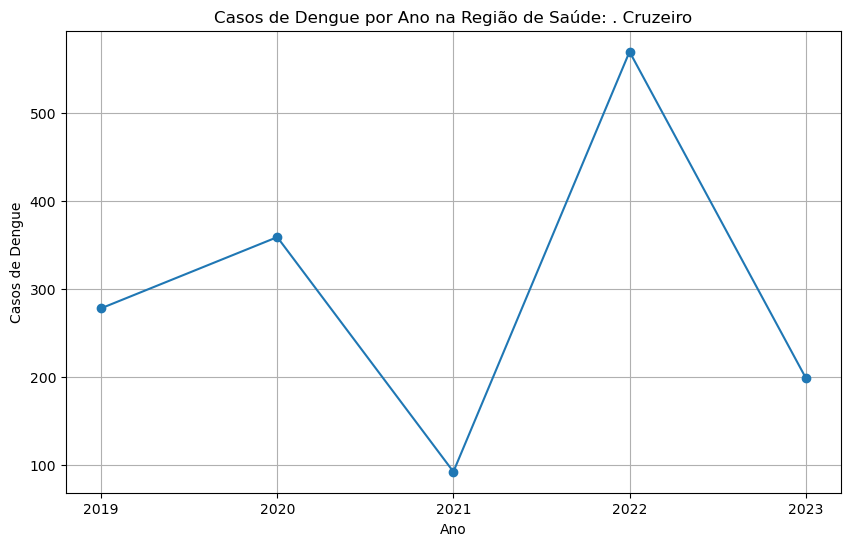

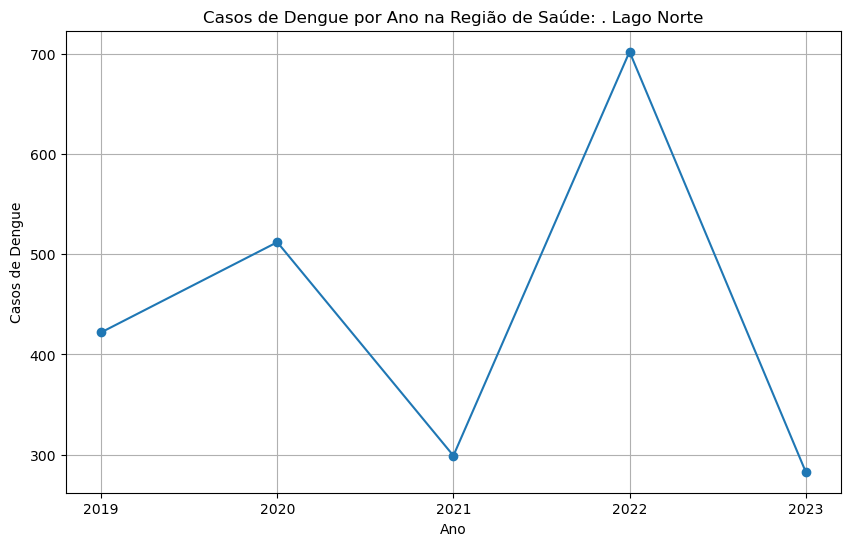

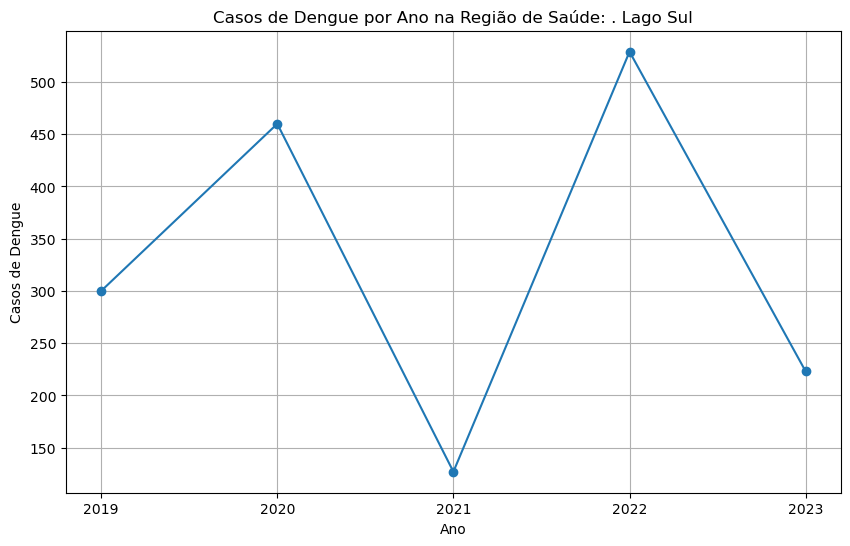

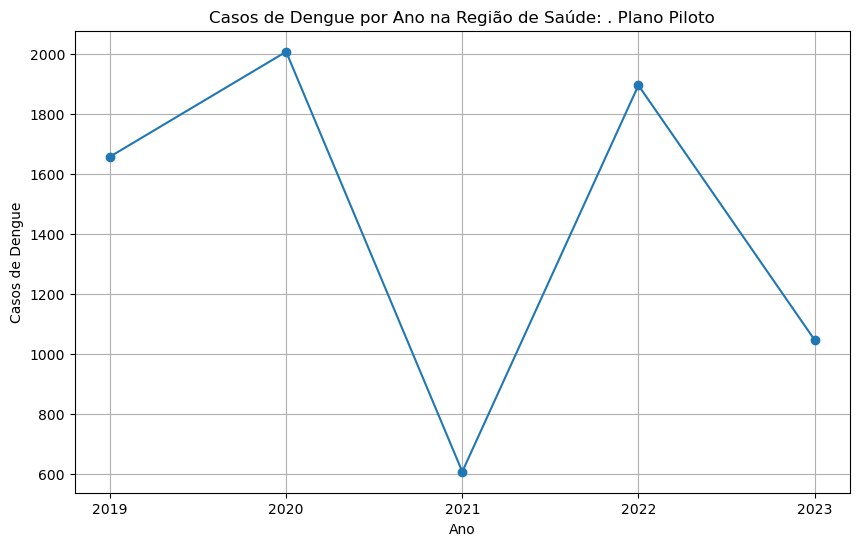

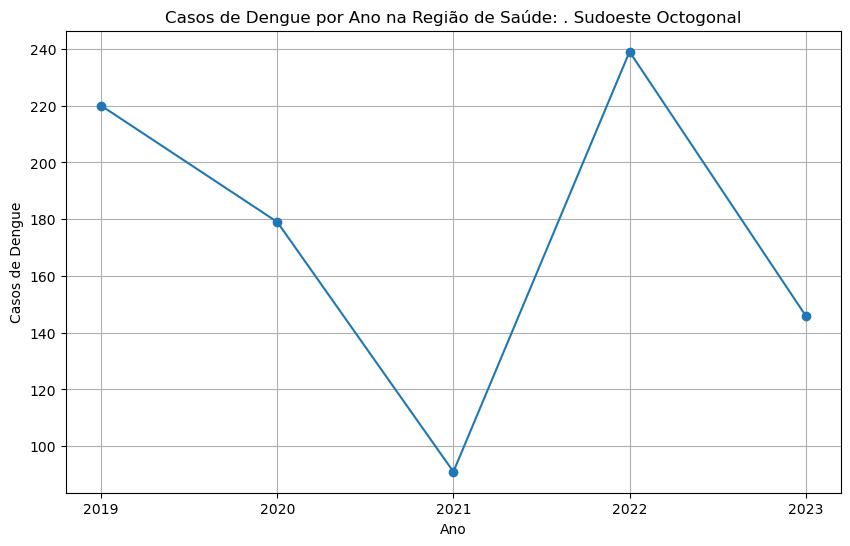

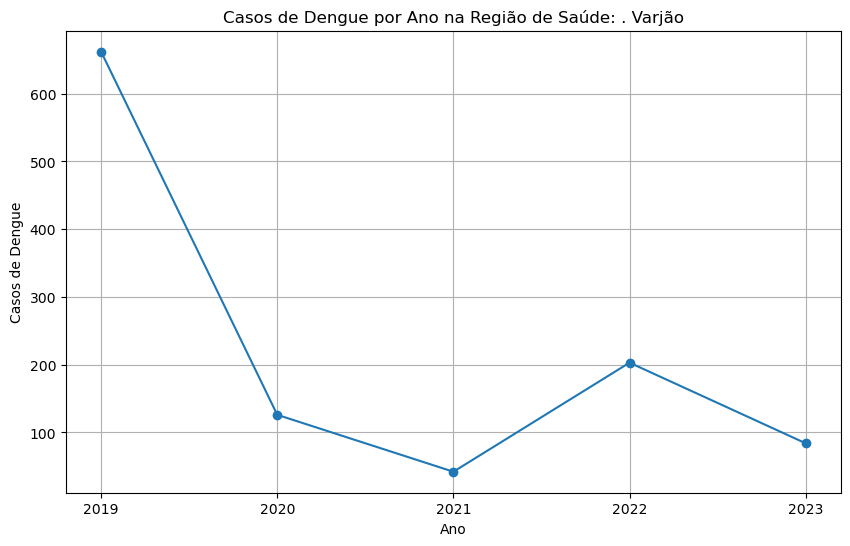

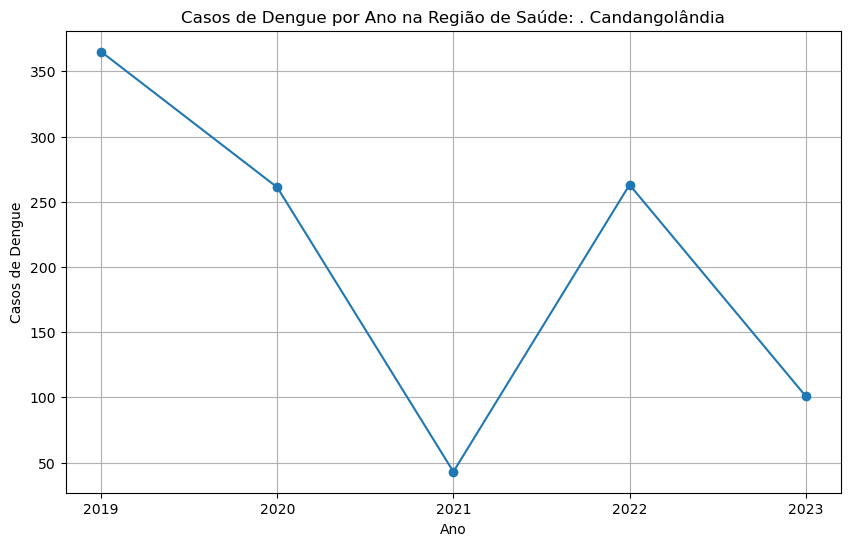

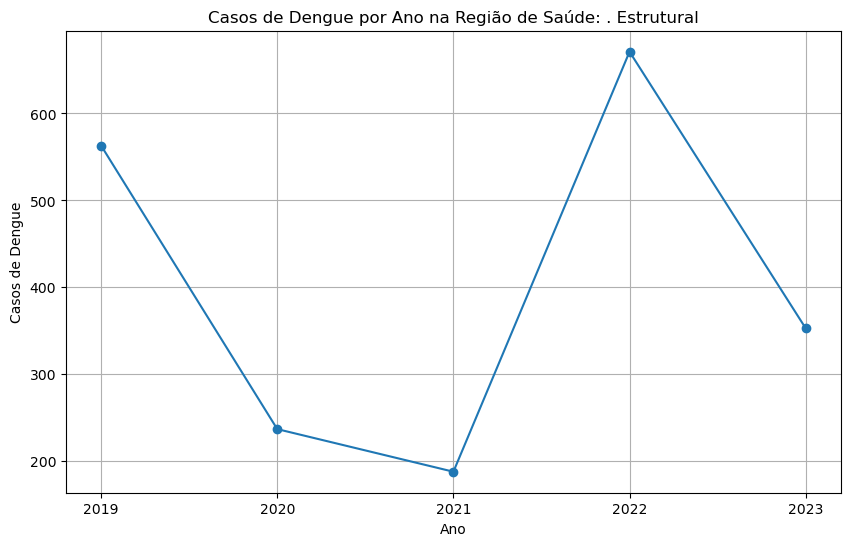

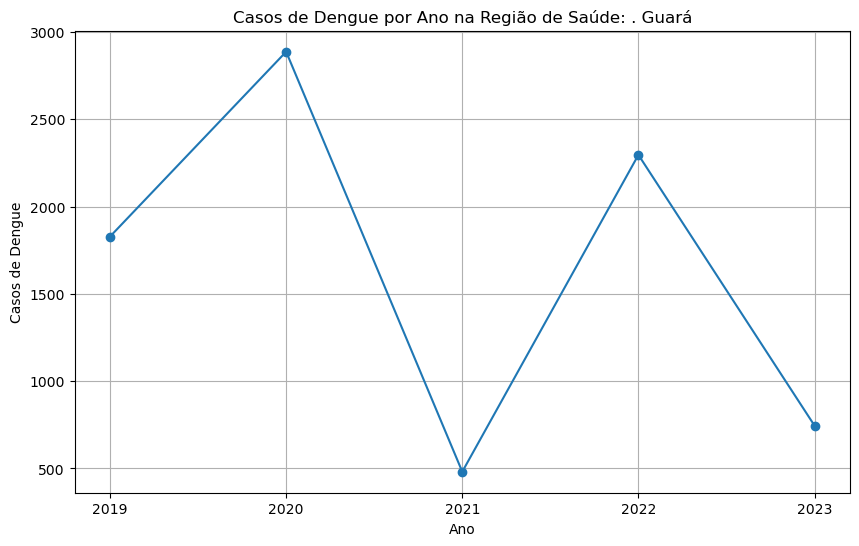

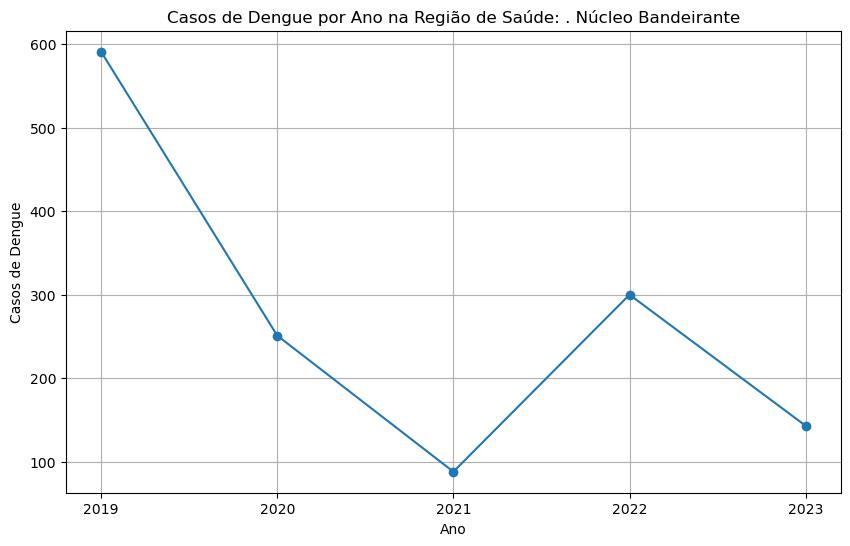

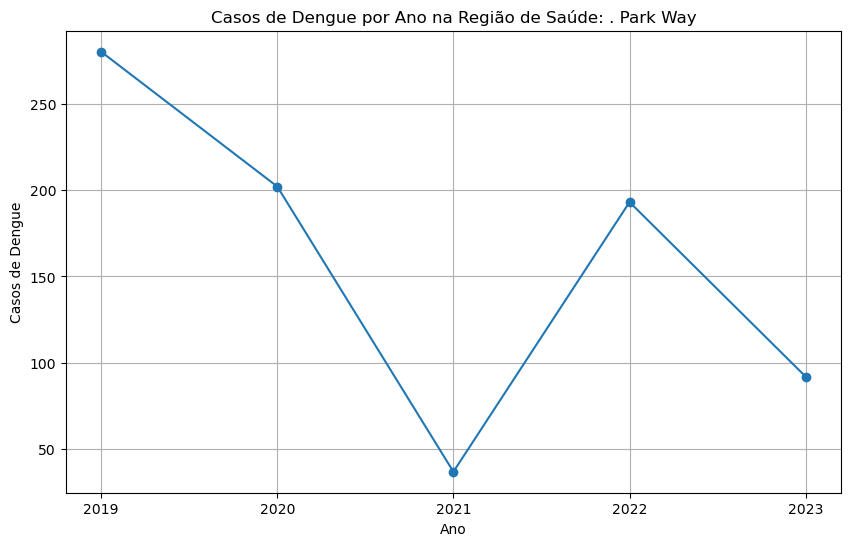

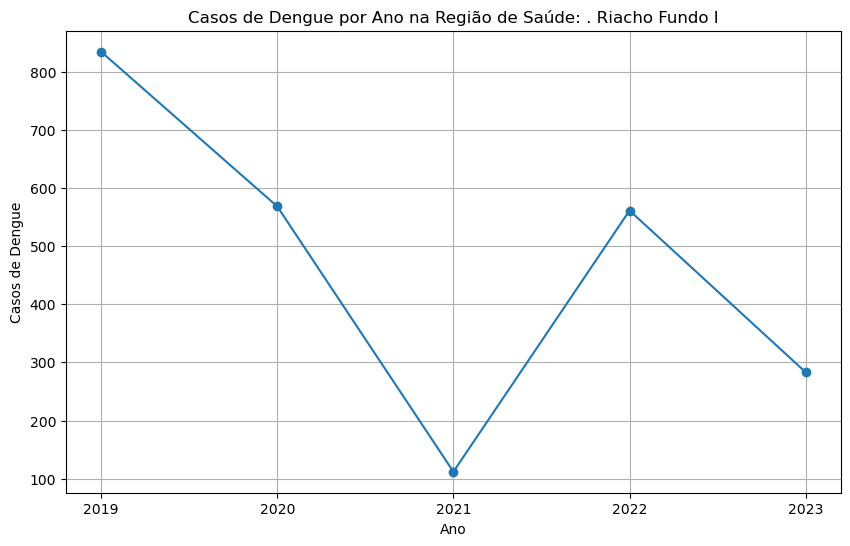

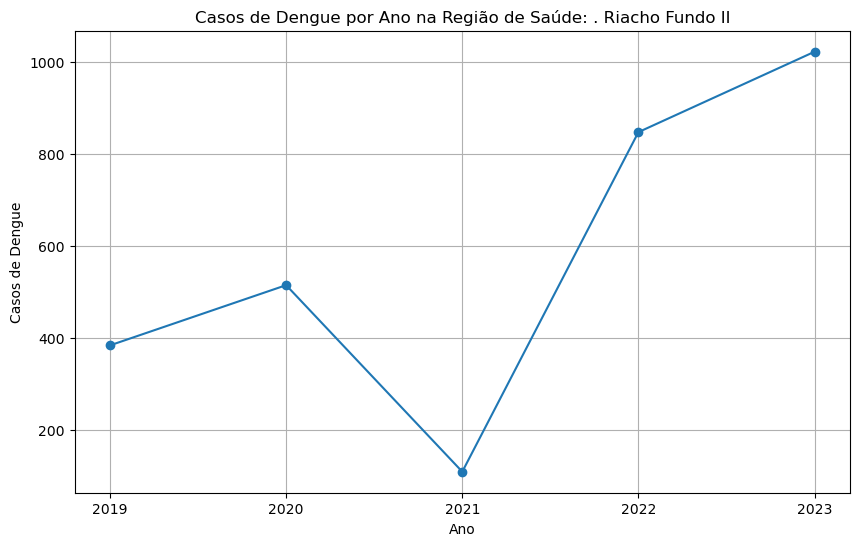

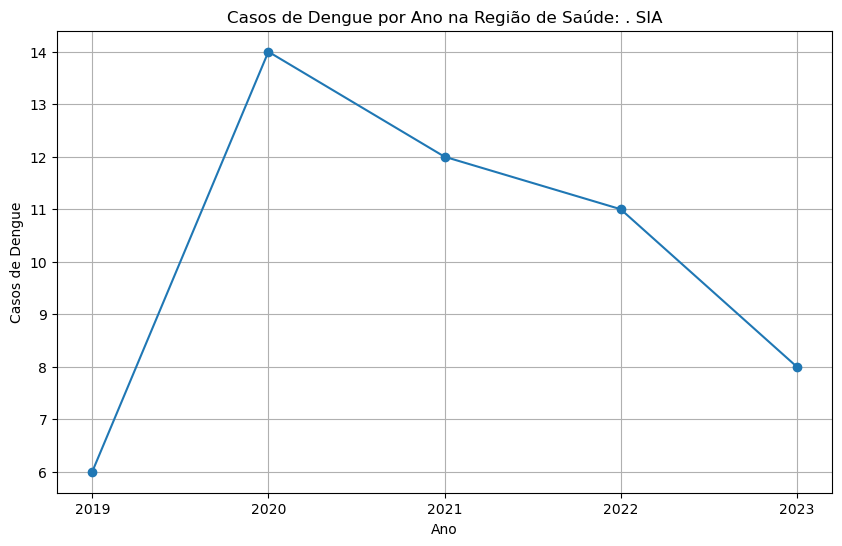

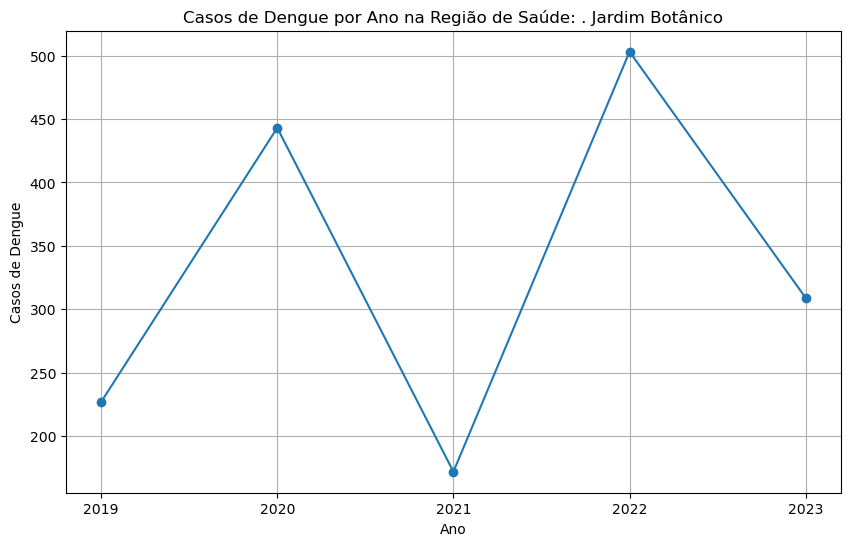

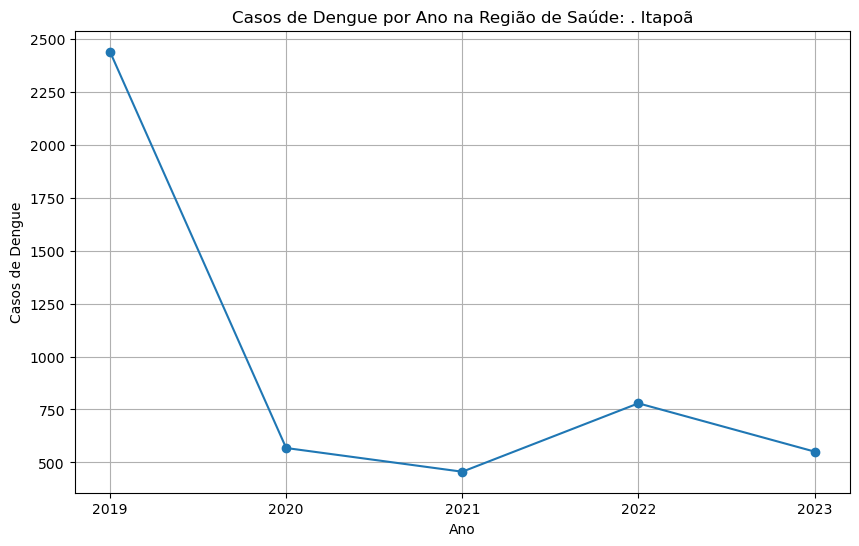

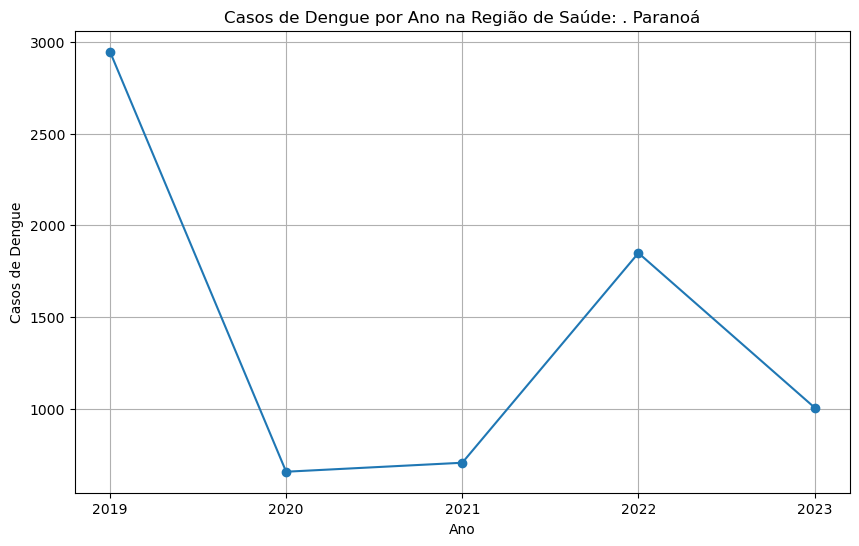

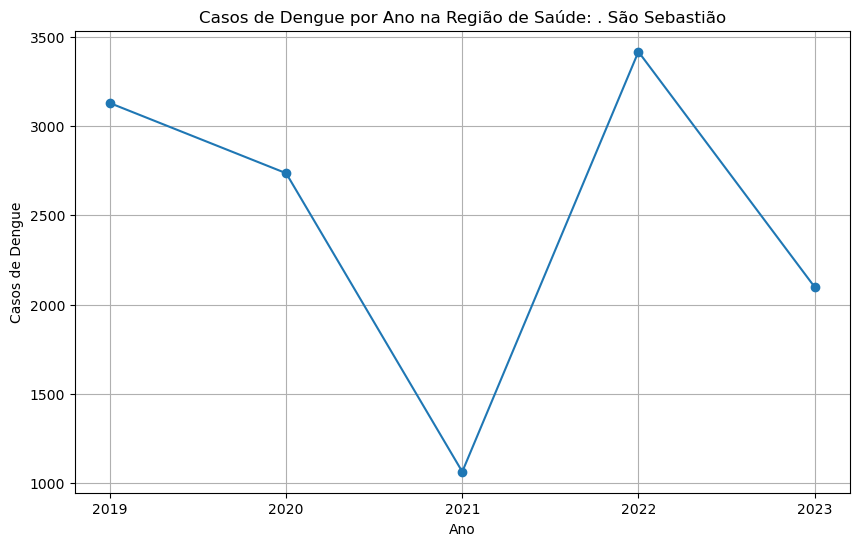

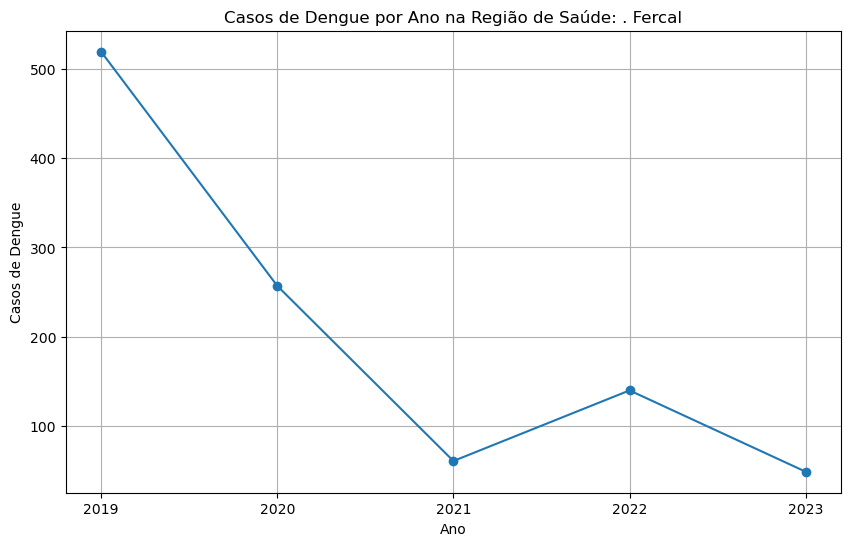

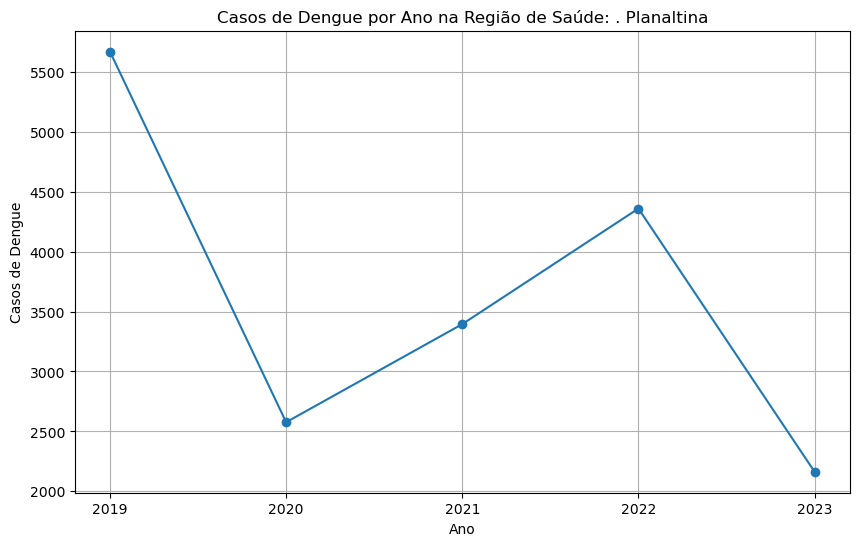

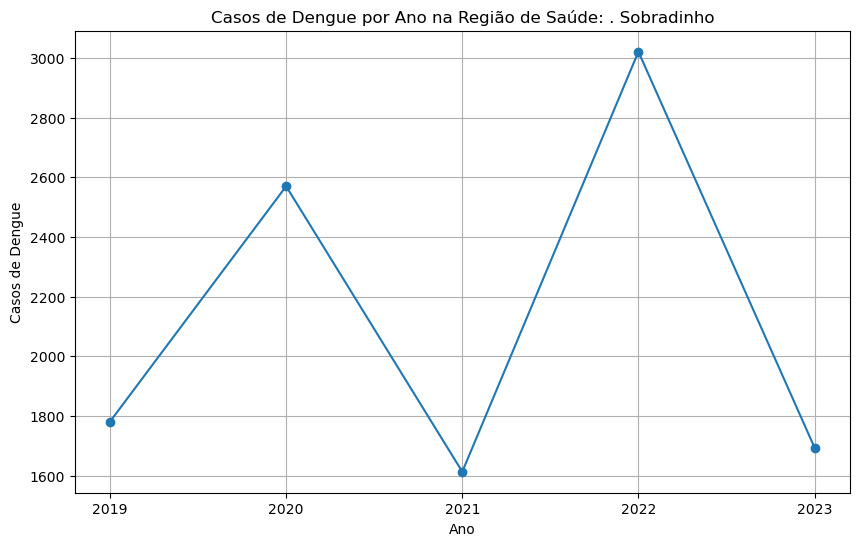

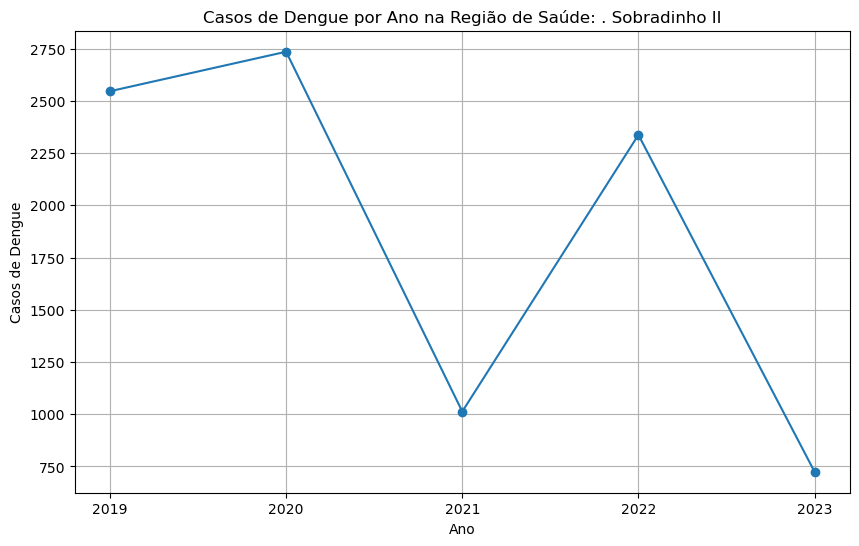

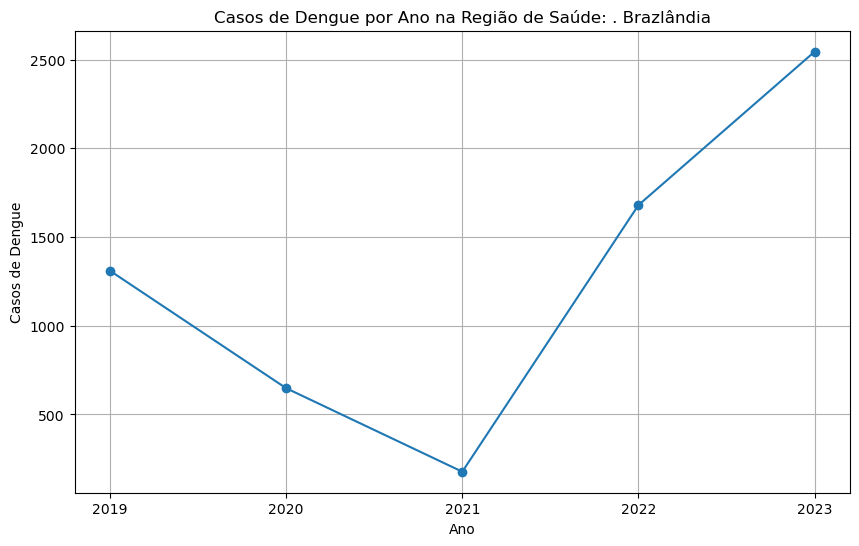

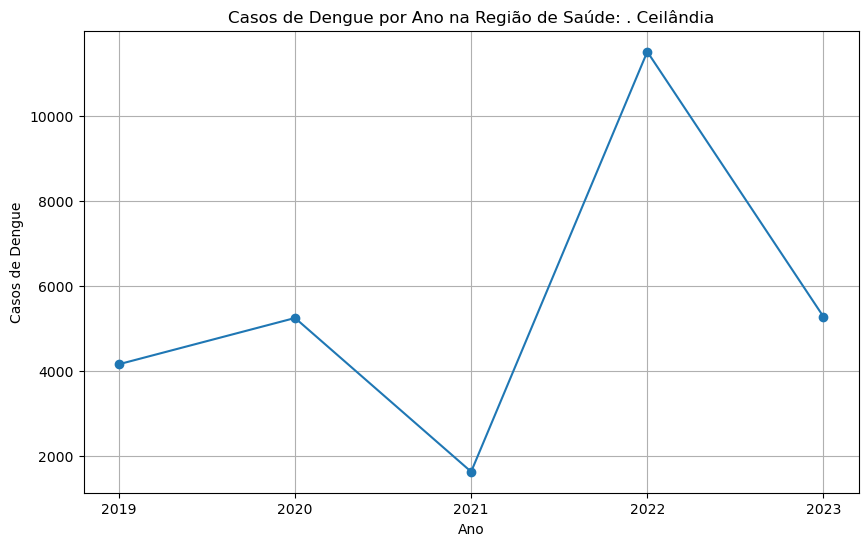

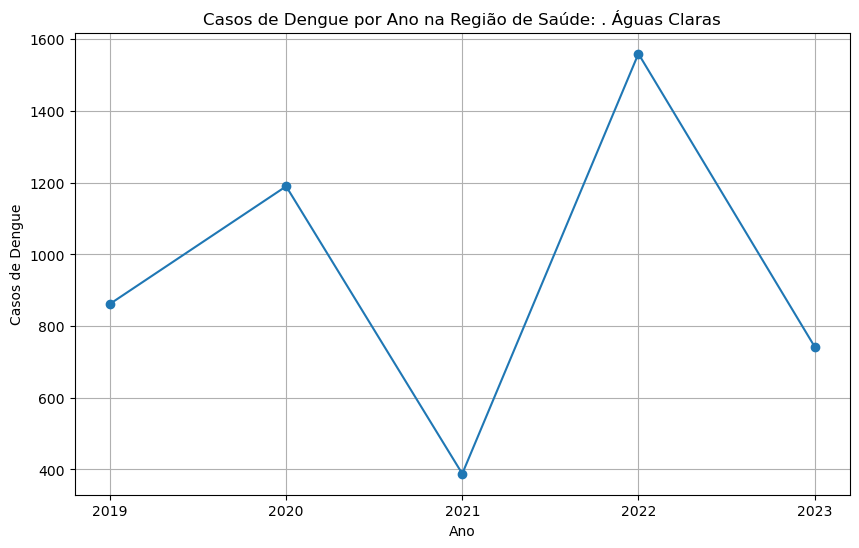

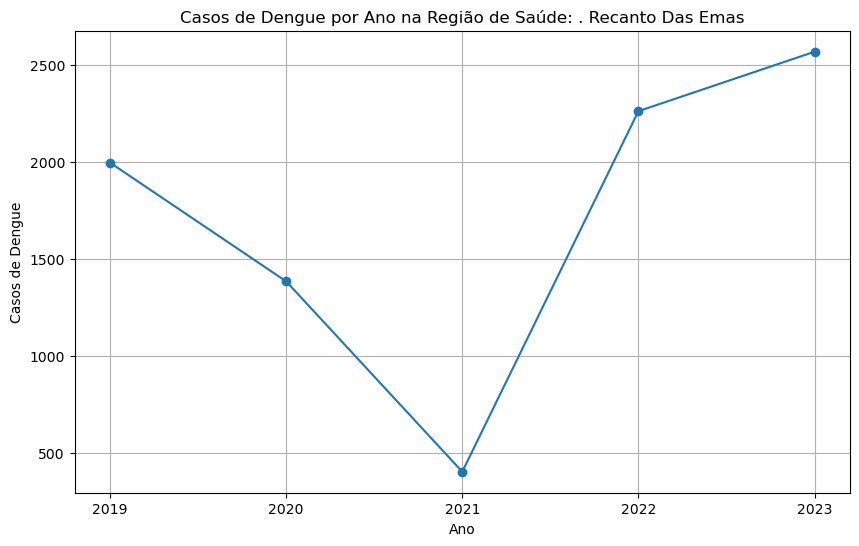

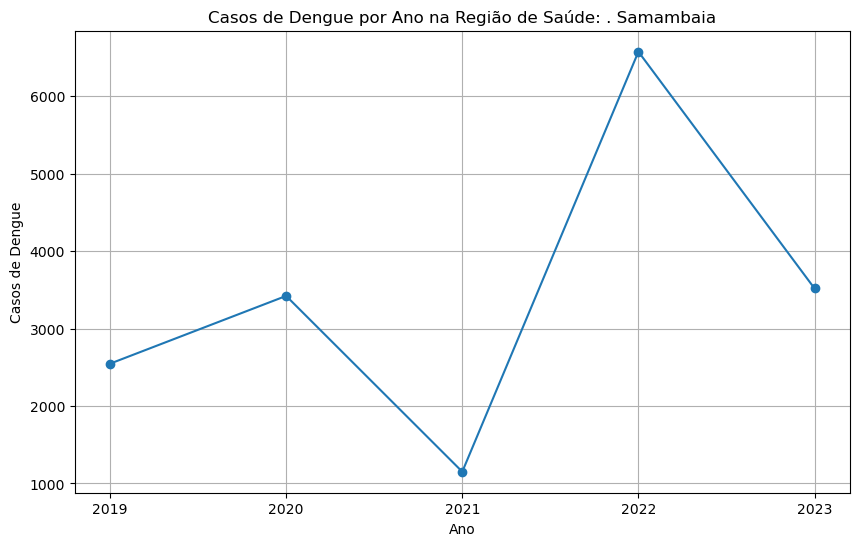

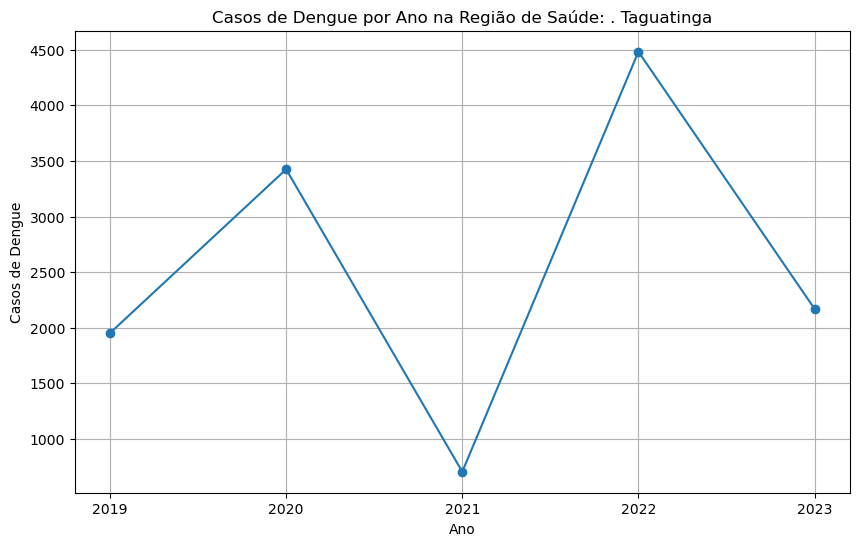

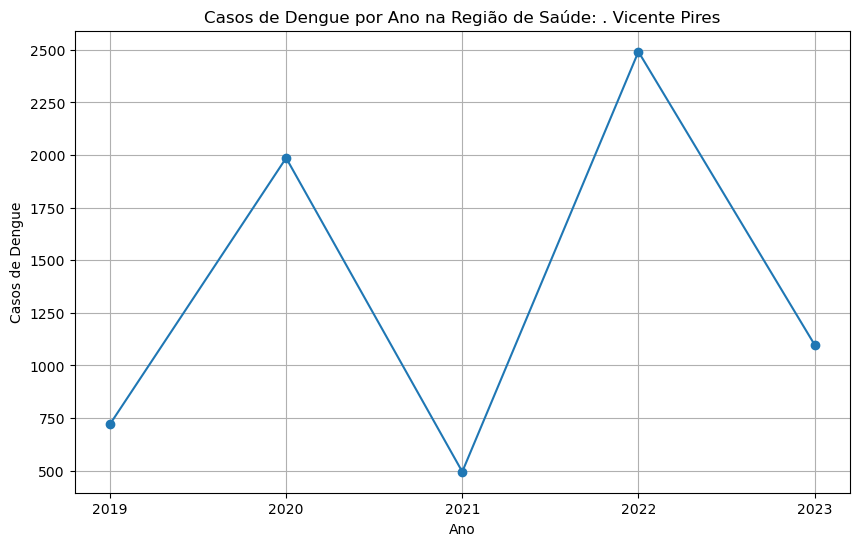

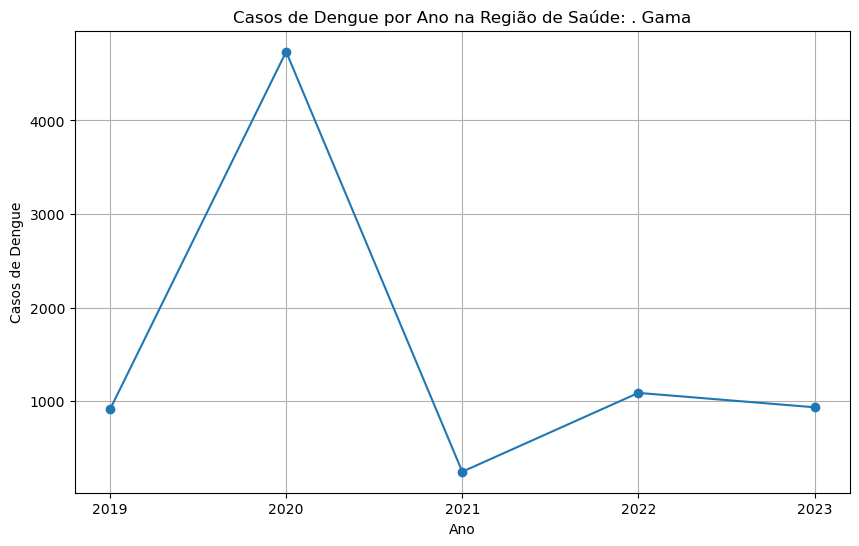

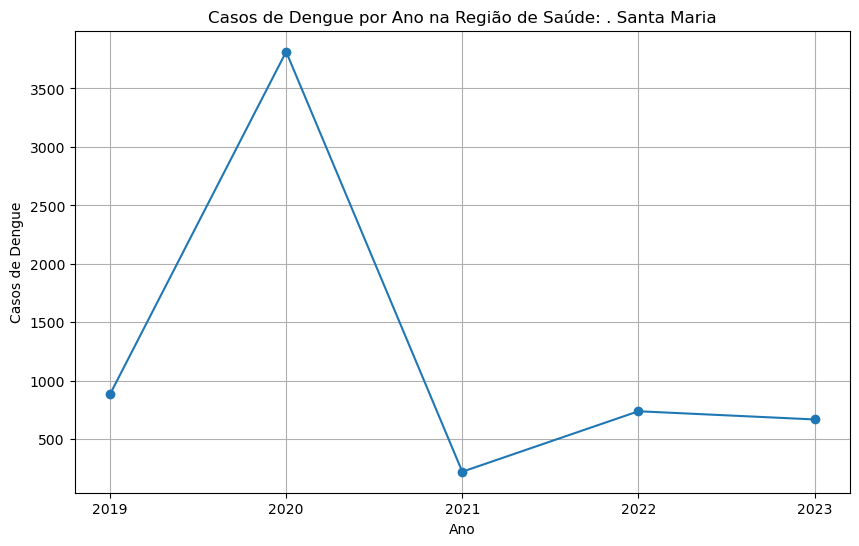

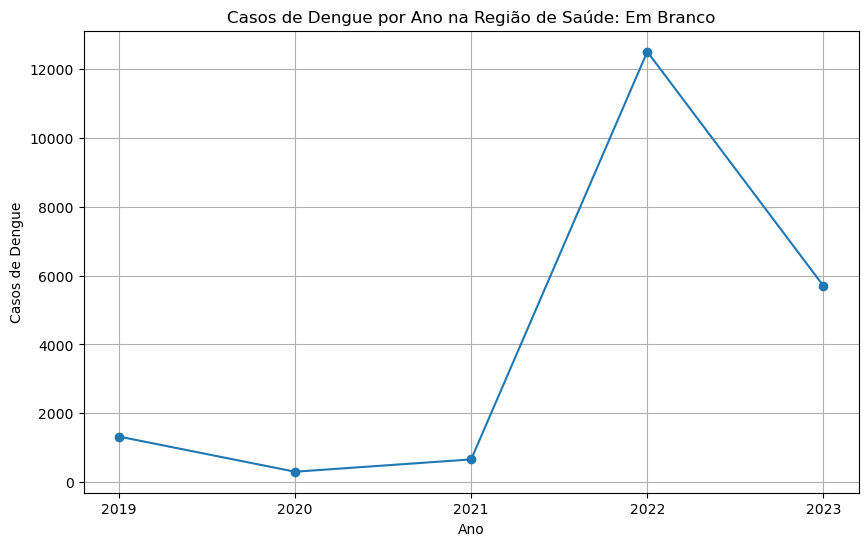

In [88]:
plotar_casos_dengue_por_regiao(linhas_cidades)

**Demostra a porcentagem de casos de cada cidade do DF**

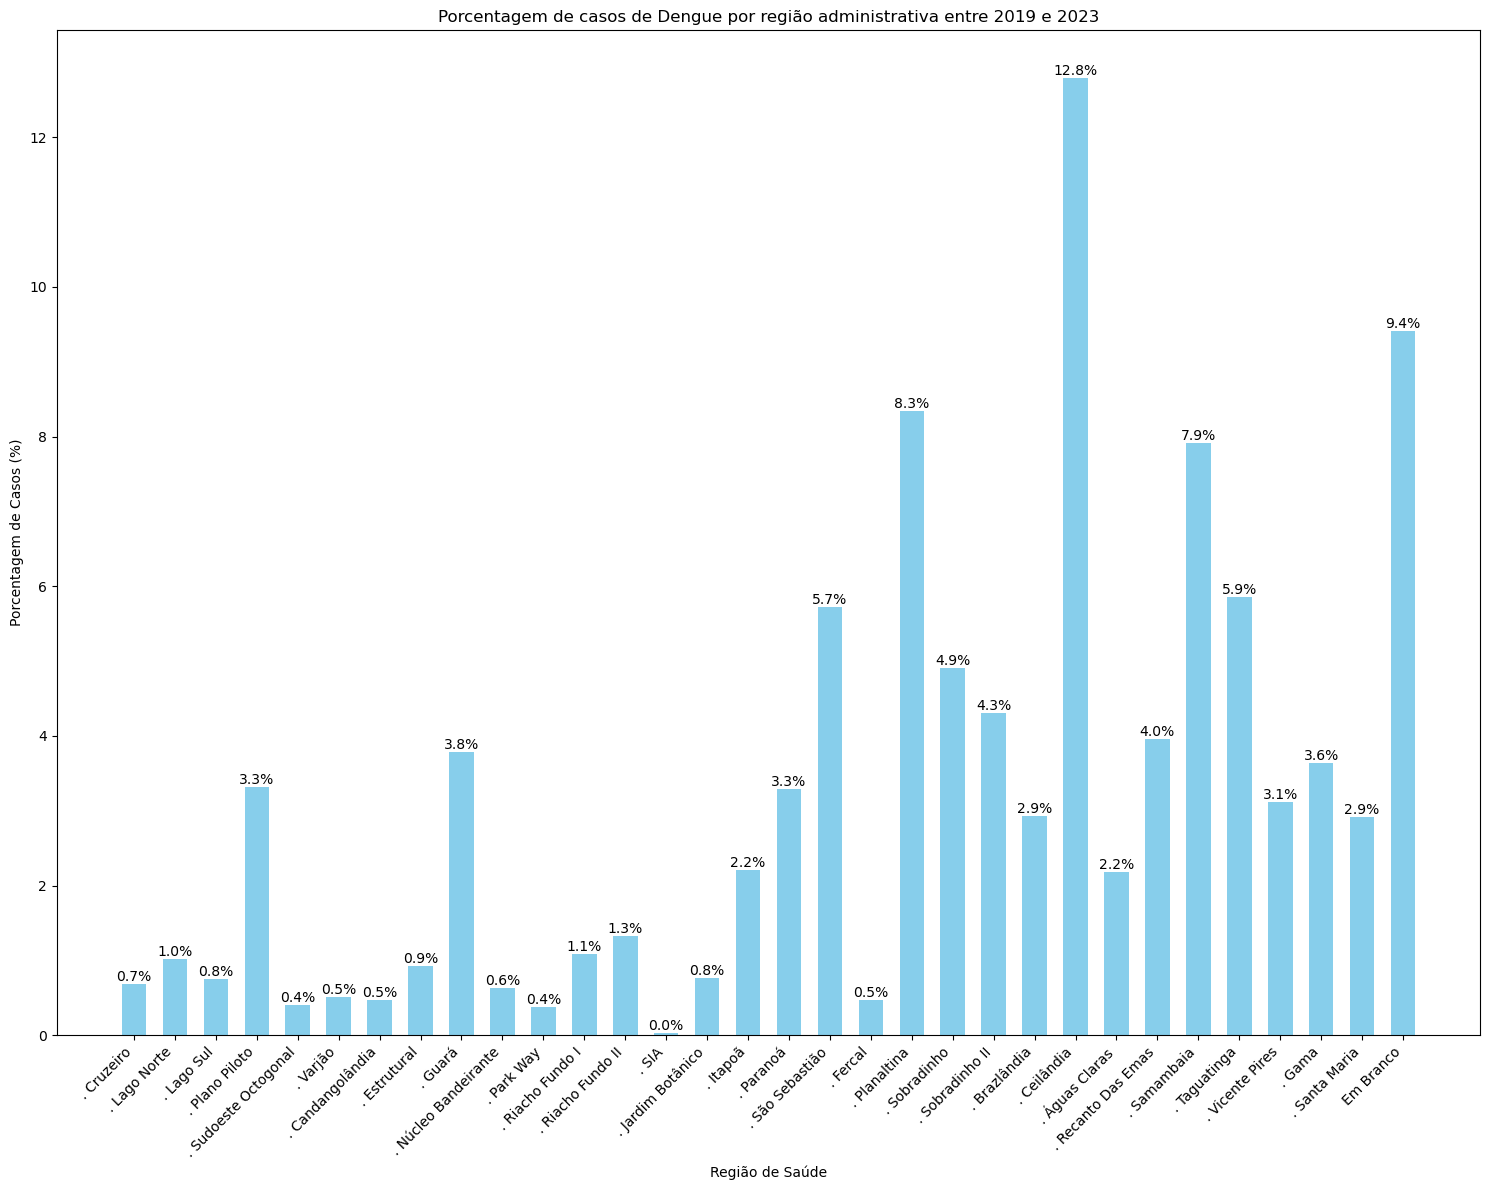

In [89]:
plot_porcentagens_cidades(df_cidade)

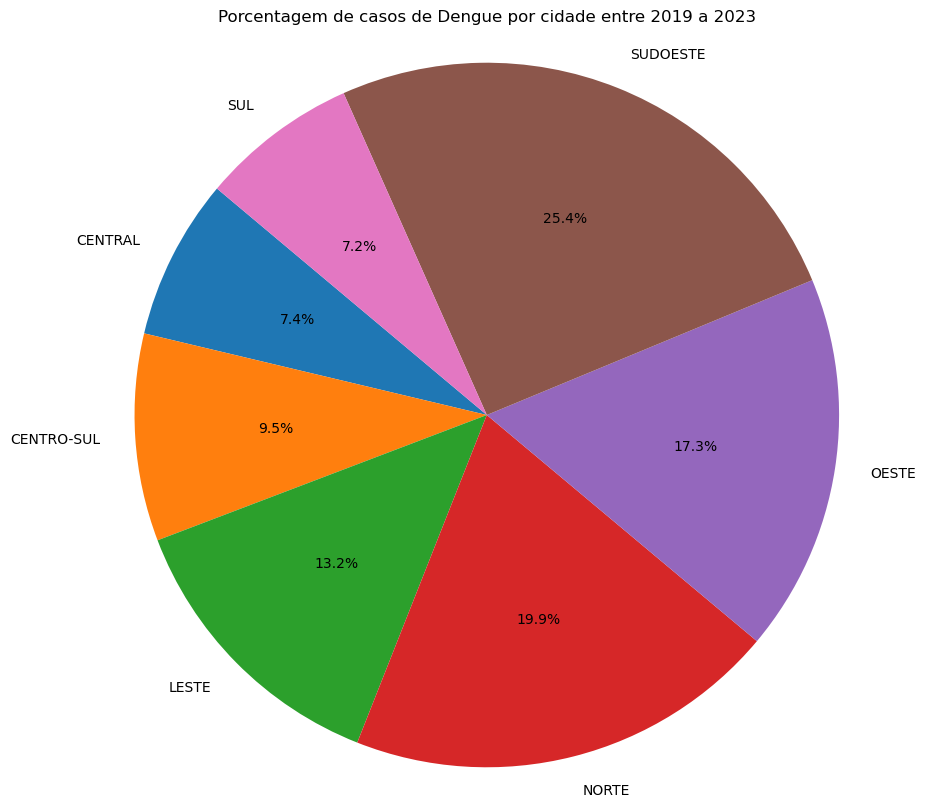

In [90]:
plot_porcentagens_regioes(df_regiao)

**Cria um mapa de calor que representa a incidência de casos de Dengue nos Subdistritos, utilizando dados de um arquivo Excel e geometrias de um arquivo GeoJSON.**

In [91]:

nome_arquivo_geojson = "mapa - Copia.json"
nome_arquivo_excel = "subdistritos.xlsx"
mapa_dengue = criar_mapa_dengue(nome_arquivo_geojson, nome_arquivo_excel)
mapa_dengue


Previsões para os próximos 5 anos para . Cruzeiro:
Ano: 2024  - Casos previstos: 268.0
Ano: 2025  - Casos previstos: 266.0
Ano: 2026  - Casos previstos: 264.0
Ano: 2027  - Casos previstos: 262.0
Ano: 2028  - Casos previstos: 260.0


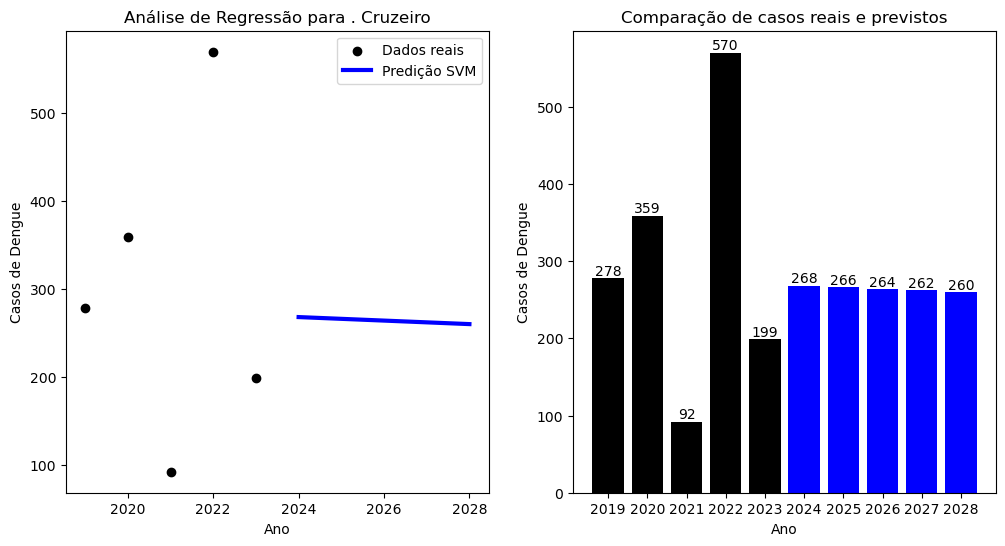

Previsões para os próximos 5 anos para . Lago Norte:
Ano: 2024  - Casos previstos: 412.0
Ano: 2025  - Casos previstos: 410.0
Ano: 2026  - Casos previstos: 408.0
Ano: 2027  - Casos previstos: 406.0
Ano: 2028  - Casos previstos: 404.0


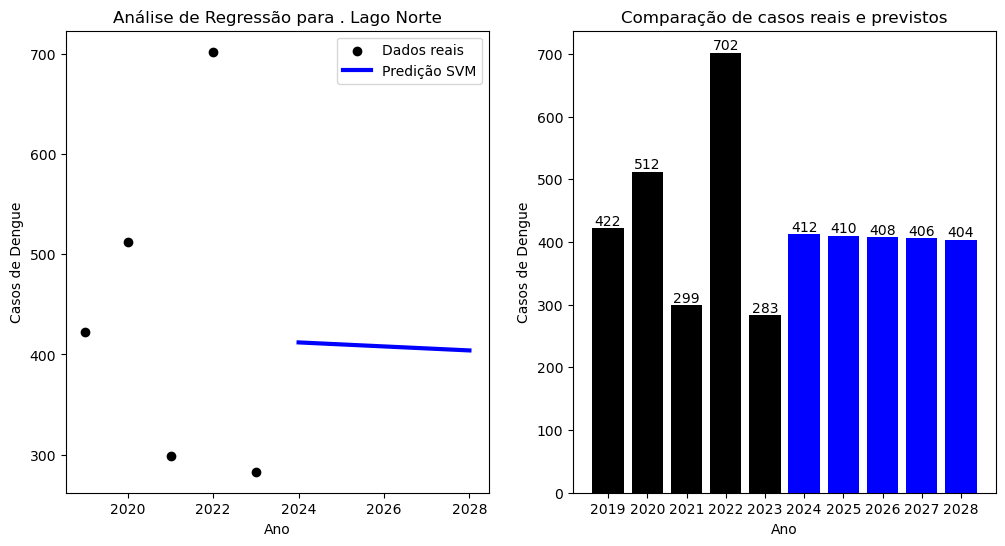

Previsões para os próximos 5 anos para . Lago Sul:
Ano: 2024  - Casos previstos: 290.0
Ano: 2025  - Casos previstos: 288.0
Ano: 2026  - Casos previstos: 286.0
Ano: 2027  - Casos previstos: 284.0
Ano: 2028  - Casos previstos: 282.0


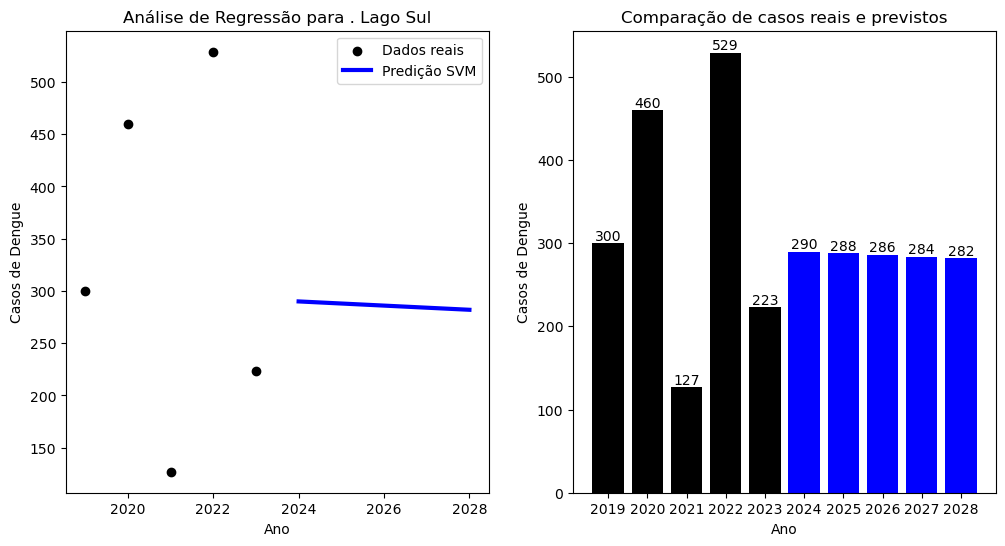

Previsões para os próximos 5 anos para . Plano Piloto:
Ano: 2024  - Casos previstos: 1648.0
Ano: 2025  - Casos previstos: 1646.0
Ano: 2026  - Casos previstos: 1644.0
Ano: 2027  - Casos previstos: 1642.0
Ano: 2028  - Casos previstos: 1640.0


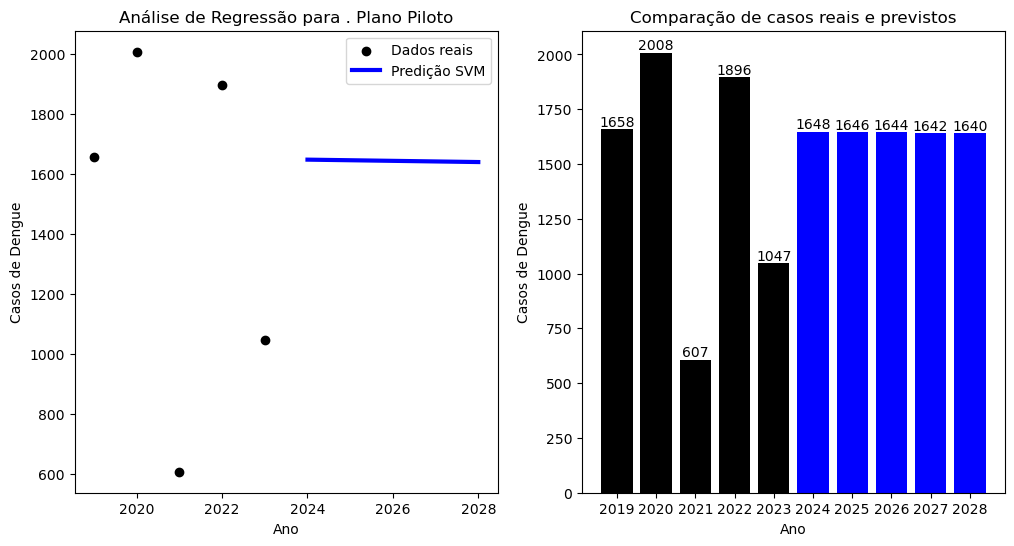

Previsões para os próximos 5 anos para . Sudoeste Octogonal:
Ano: 2024  - Casos previstos: 167.0
Ano: 2025  - Casos previstos: 164.0
Ano: 2026  - Casos previstos: 161.0
Ano: 2027  - Casos previstos: 158.0
Ano: 2028  - Casos previstos: 155.0


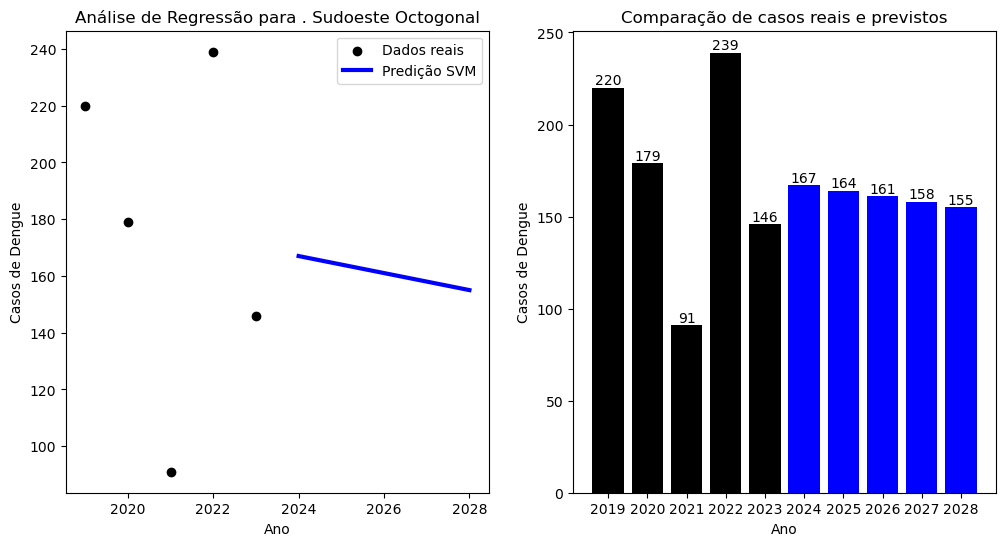

Previsões para os próximos 5 anos para . Varjão:
Ano: 2024  - Casos previstos: 114.0
Ano: 2025  - Casos previstos: 111.0
Ano: 2026  - Casos previstos: 108.0
Ano: 2027  - Casos previstos: 105.0
Ano: 2028  - Casos previstos: 102.0


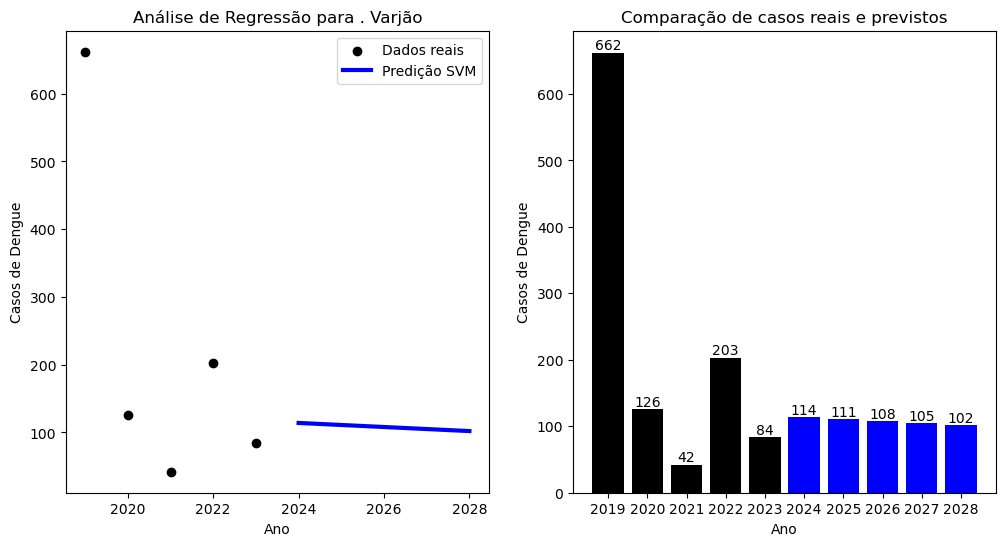

Previsões para os próximos 5 anos para . Candangolândia:
Ano: 2024  - Casos previstos: 249.0
Ano: 2025  - Casos previstos: 246.0
Ano: 2026  - Casos previstos: 243.0
Ano: 2027  - Casos previstos: 240.0
Ano: 2028  - Casos previstos: 237.0


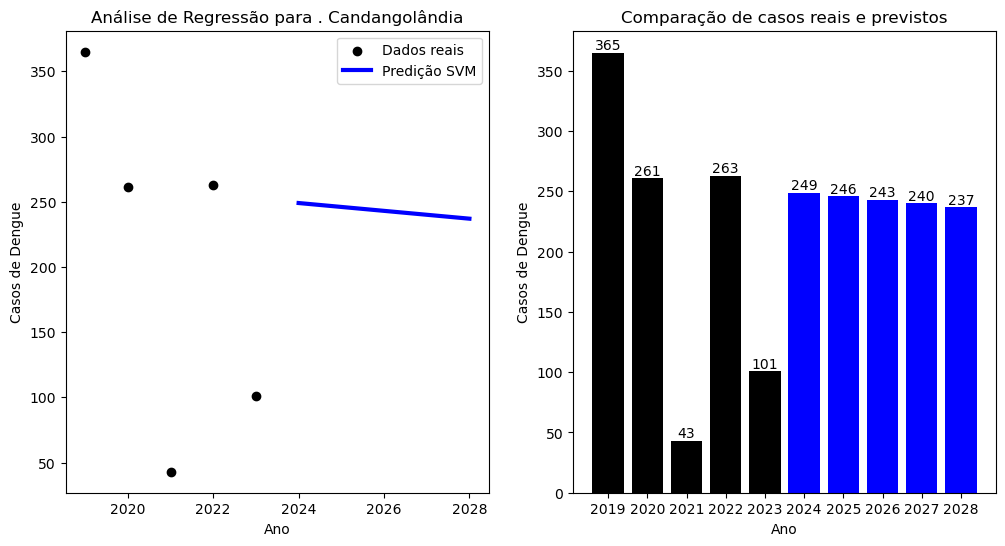

Previsões para os próximos 5 anos para . Estrutural:
Ano: 2024  - Casos previstos: 353.0
Ano: 2025  - Casos previstos: 353.0
Ano: 2026  - Casos previstos: 353.0
Ano: 2027  - Casos previstos: 353.0
Ano: 2028  - Casos previstos: 353.0


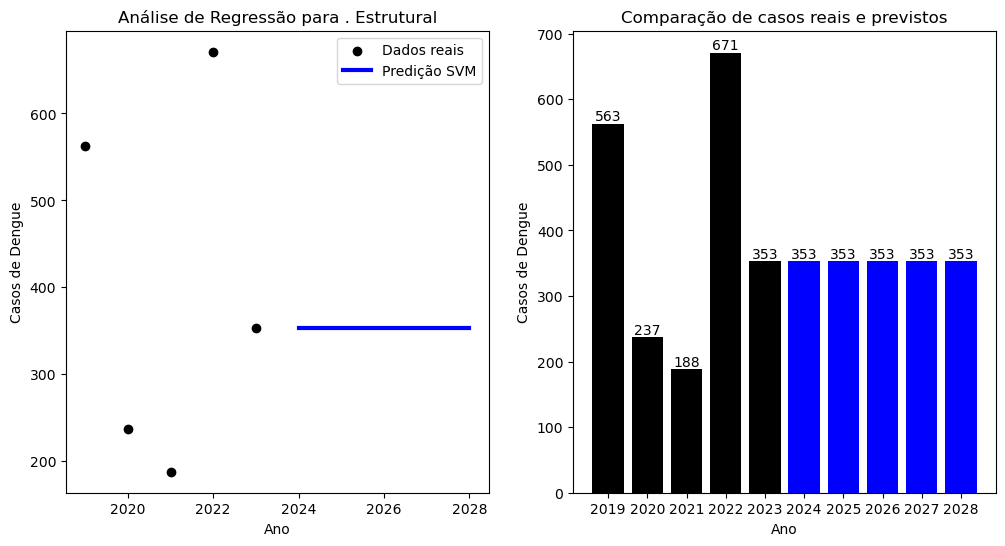

Previsões para os próximos 5 anos para . Guará:
Ano: 2024  - Casos previstos: 1818.0
Ano: 2025  - Casos previstos: 1816.0
Ano: 2026  - Casos previstos: 1814.0
Ano: 2027  - Casos previstos: 1812.0
Ano: 2028  - Casos previstos: 1810.0


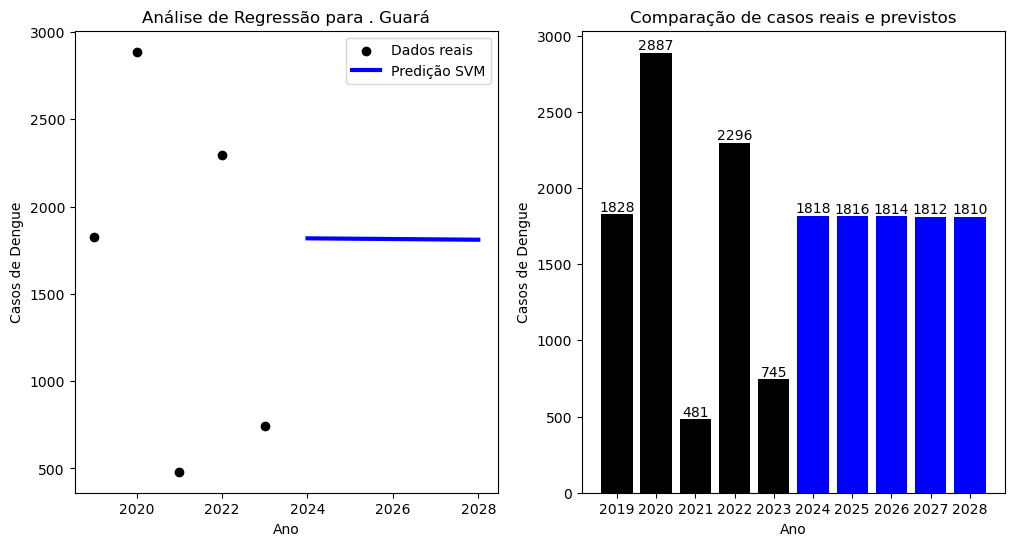

Previsões para os próximos 5 anos para . Núcleo Bandeirante:
Ano: 2024  - Casos previstos: 239.0
Ano: 2025  - Casos previstos: 236.0
Ano: 2026  - Casos previstos: 233.0
Ano: 2027  - Casos previstos: 230.0
Ano: 2028  - Casos previstos: 227.0


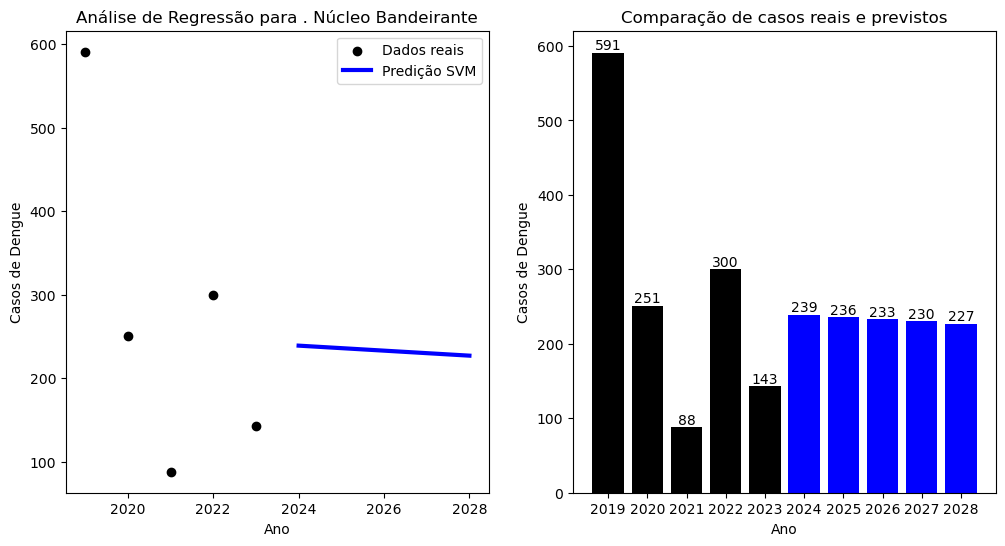

Previsões para os próximos 5 anos para . Park Way:
Ano: 2024  - Casos previstos: 183.89999999999964
Ano: 2025  - Casos previstos: 179.39999999999964
Ano: 2026  - Casos previstos: 174.89999999999964
Ano: 2027  - Casos previstos: 170.39999999999964
Ano: 2028  - Casos previstos: 165.89999999999964


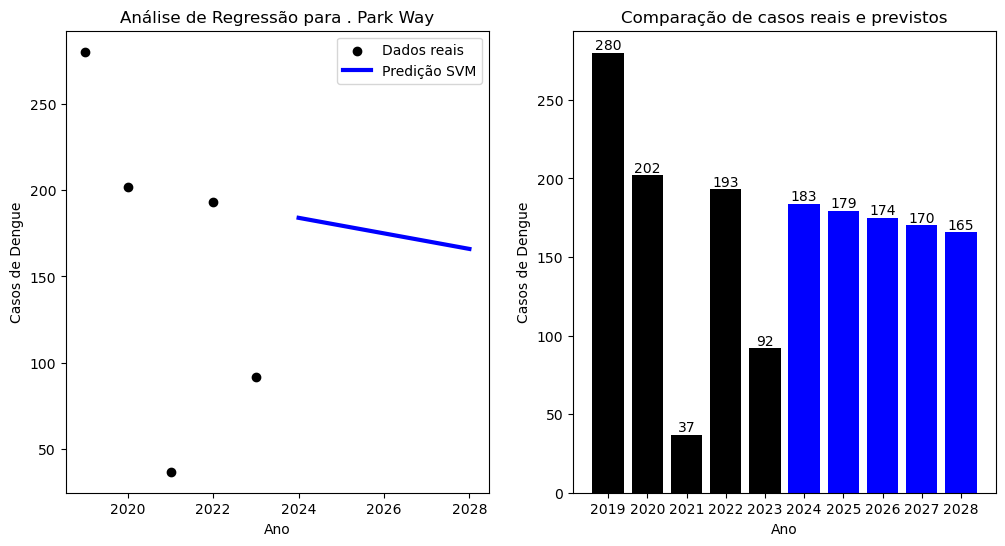

Previsões para os próximos 5 anos para . Riacho Fundo I:
Ano: 2024  - Casos previstos: 553.8999999999996
Ano: 2025  - Casos previstos: 550.3999999999996
Ano: 2026  - Casos previstos: 546.8999999999996
Ano: 2027  - Casos previstos: 543.3999999999996
Ano: 2028  - Casos previstos: 539.8999999999996


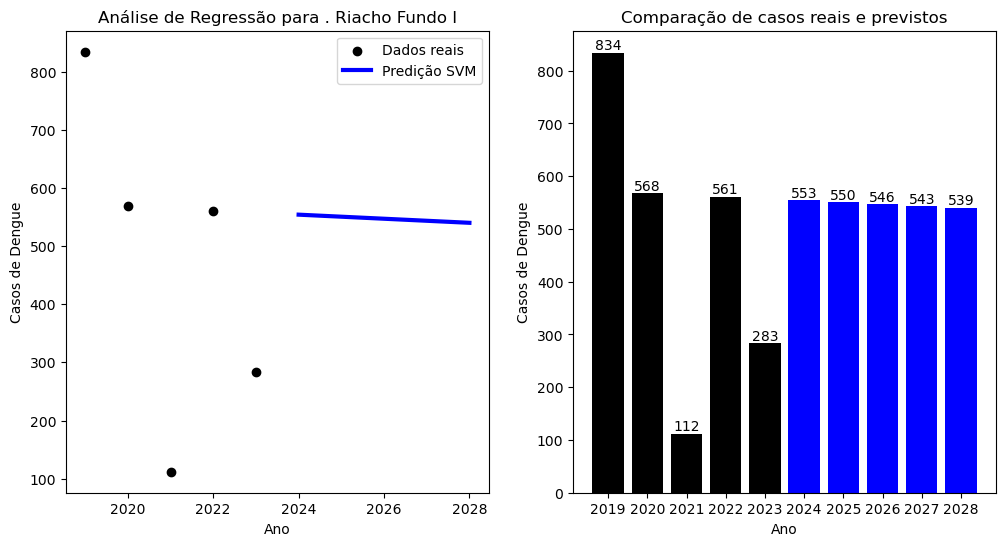

Previsões para os próximos 5 anos para . Riacho Fundo II:
Ano: 2024  - Casos previstos: 535.0
Ano: 2025  - Casos previstos: 540.0
Ano: 2026  - Casos previstos: 545.0
Ano: 2027  - Casos previstos: 550.0
Ano: 2028  - Casos previstos: 555.0


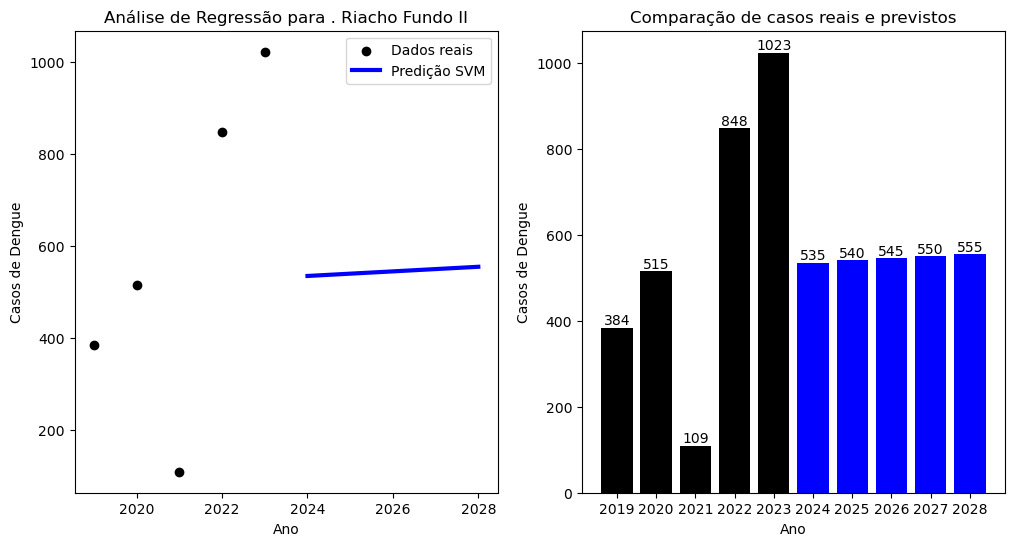

Previsões para os próximos 5 anos para . SIA:
Ano: 2024  - Casos previstos: 8.900000000000091
Ano: 2025  - Casos previstos: 7.900000000000091
Ano: 2026  - Casos previstos: 6.900000000000091
Ano: 2027  - Casos previstos: 5.900000000000091
Ano: 2028  - Casos previstos: 4.900000000000091


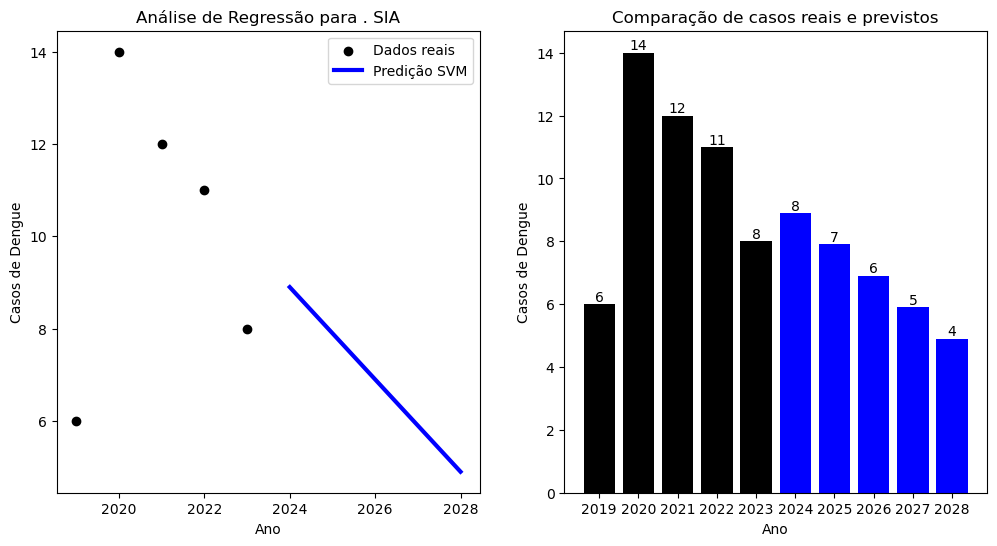

Previsões para os próximos 5 anos para . Jardim Botânico:
Ano: 2024  - Casos previstos: 311.0
Ano: 2025  - Casos previstos: 313.0
Ano: 2026  - Casos previstos: 315.0
Ano: 2027  - Casos previstos: 317.0
Ano: 2028  - Casos previstos: 319.0


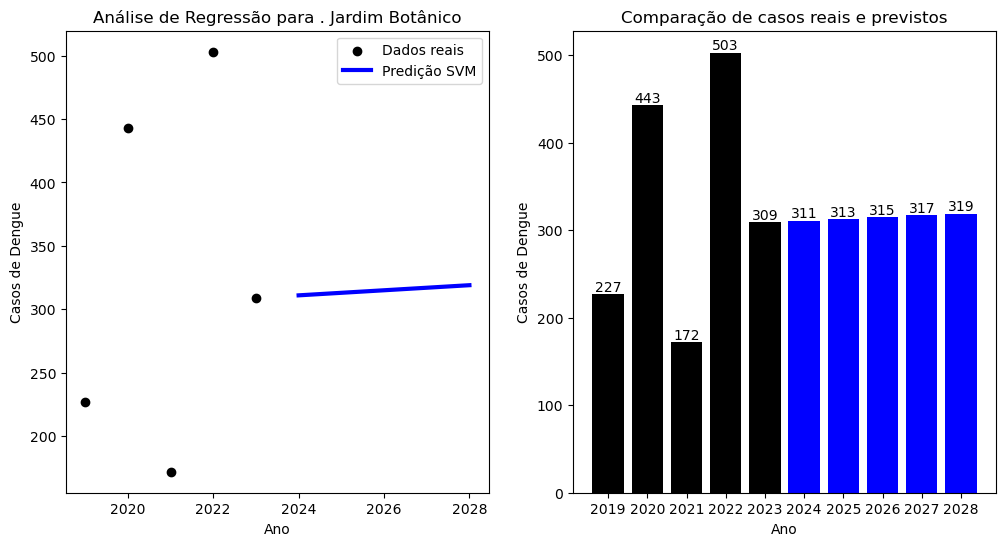

Previsões para os próximos 5 anos para . Itapoã:
Ano: 2024  - Casos previstos: 556.0
Ano: 2025  - Casos previstos: 553.0
Ano: 2026  - Casos previstos: 550.0
Ano: 2027  - Casos previstos: 547.0
Ano: 2028  - Casos previstos: 544.0


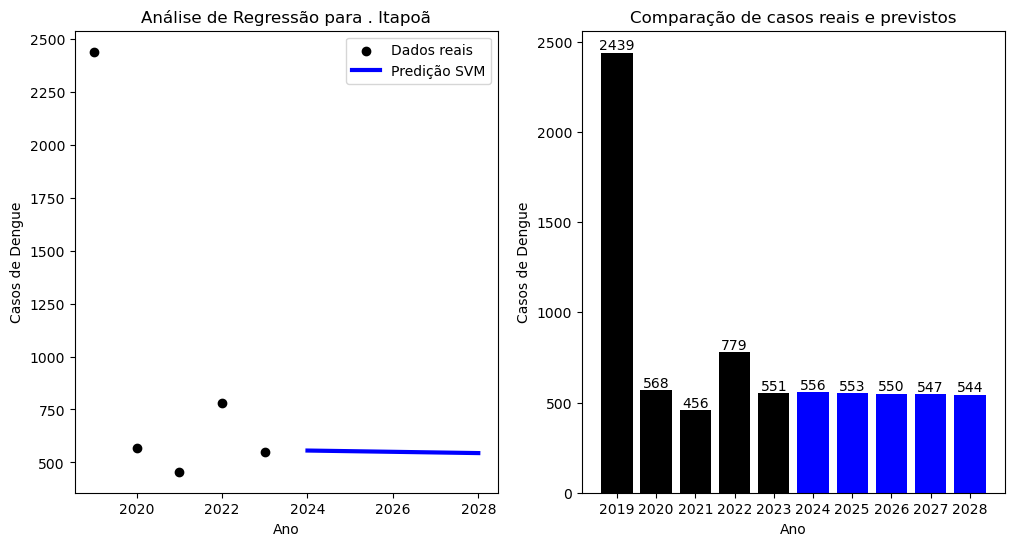

Previsões para os próximos 5 anos para . Paranoá:
Ano: 2024  - Casos previstos: 1006.0
Ano: 2025  - Casos previstos: 1006.0
Ano: 2026  - Casos previstos: 1006.0
Ano: 2027  - Casos previstos: 1006.0
Ano: 2028  - Casos previstos: 1006.0


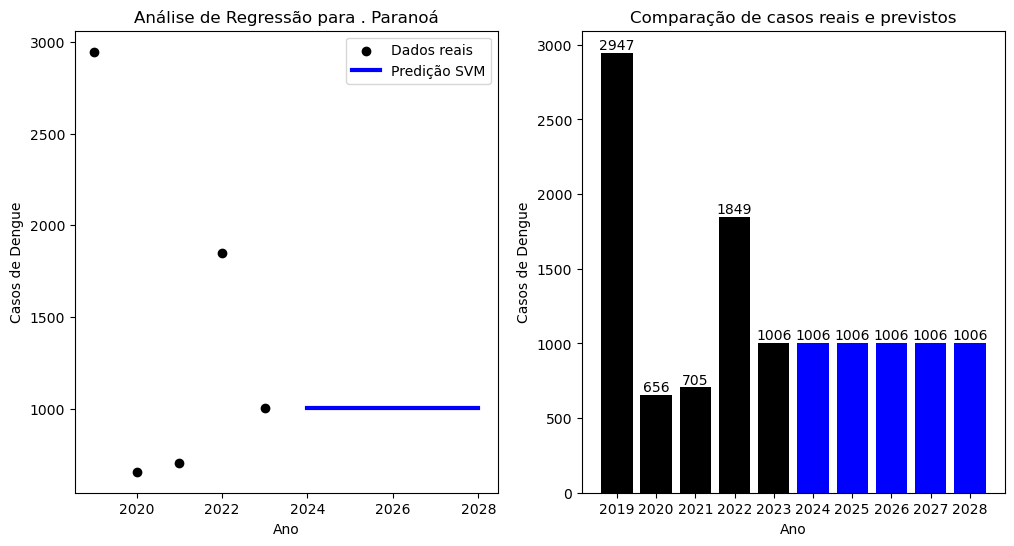

Previsões para os próximos 5 anos para . São Sebastião:
Ano: 2024  - Casos previstos: 2724.0
Ano: 2025  - Casos previstos: 2721.0
Ano: 2026  - Casos previstos: 2718.0
Ano: 2027  - Casos previstos: 2715.0
Ano: 2028  - Casos previstos: 2712.0


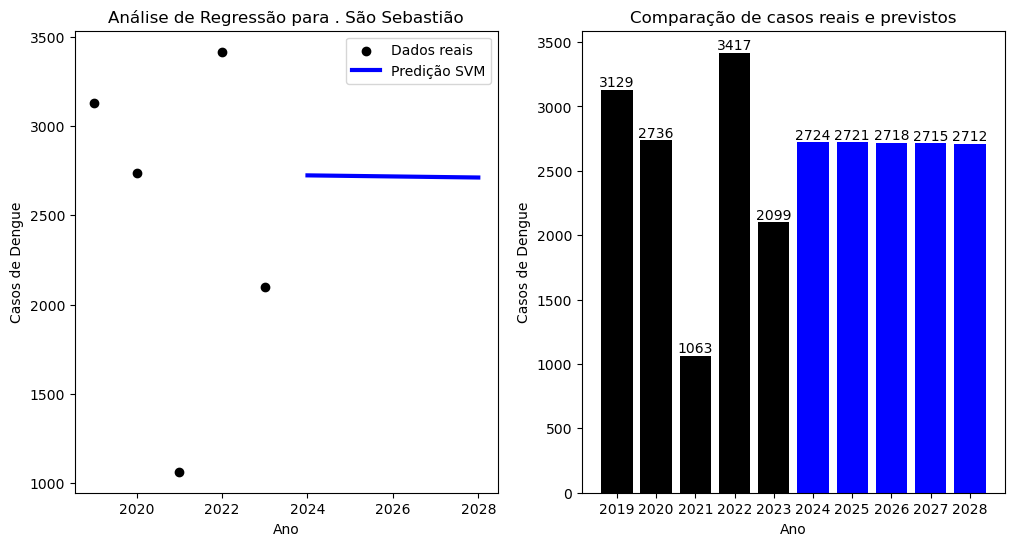

Previsões para os próximos 5 anos para . Fercal:
Ano: 2024  - Casos previstos: 130.0
Ano: 2025  - Casos previstos: 125.0
Ano: 2026  - Casos previstos: 120.0
Ano: 2027  - Casos previstos: 115.0
Ano: 2028  - Casos previstos: 110.0


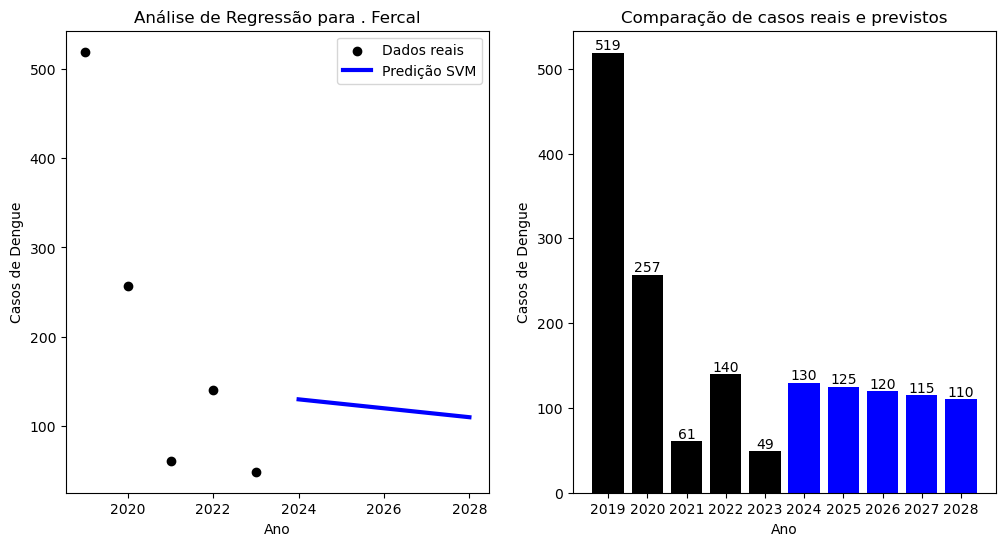

Previsões para os próximos 5 anos para . Planaltina:
Ano: 2024  - Casos previstos: 3389.0
Ano: 2025  - Casos previstos: 3387.0
Ano: 2026  - Casos previstos: 3385.0
Ano: 2027  - Casos previstos: 3383.0
Ano: 2028  - Casos previstos: 3381.0


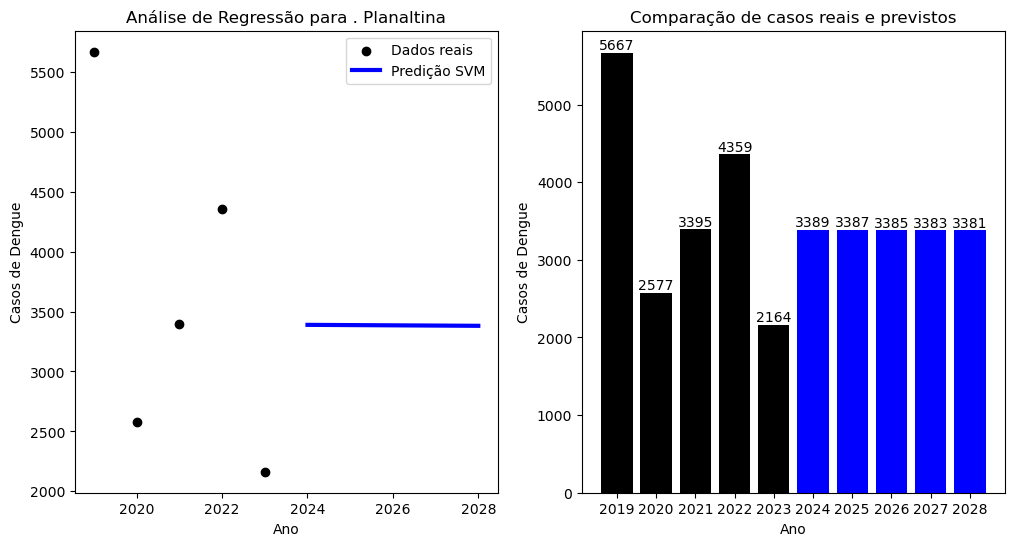

Previsões para os próximos 5 anos para . Sobradinho:
Ano: 2024  - Casos previstos: 1771.0
Ano: 2025  - Casos previstos: 1769.0
Ano: 2026  - Casos previstos: 1767.0
Ano: 2027  - Casos previstos: 1765.0
Ano: 2028  - Casos previstos: 1763.0


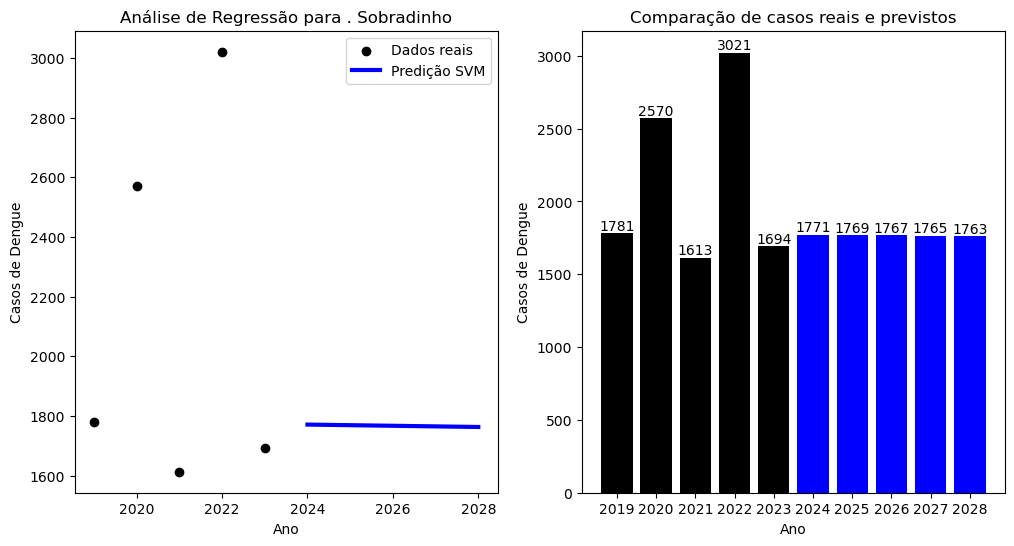

Previsões para os próximos 5 anos para . Sobradinho II:
Ano: 2024  - Casos previstos: 2327.0
Ano: 2025  - Casos previstos: 2322.0
Ano: 2026  - Casos previstos: 2317.0
Ano: 2027  - Casos previstos: 2312.0
Ano: 2028  - Casos previstos: 2307.0


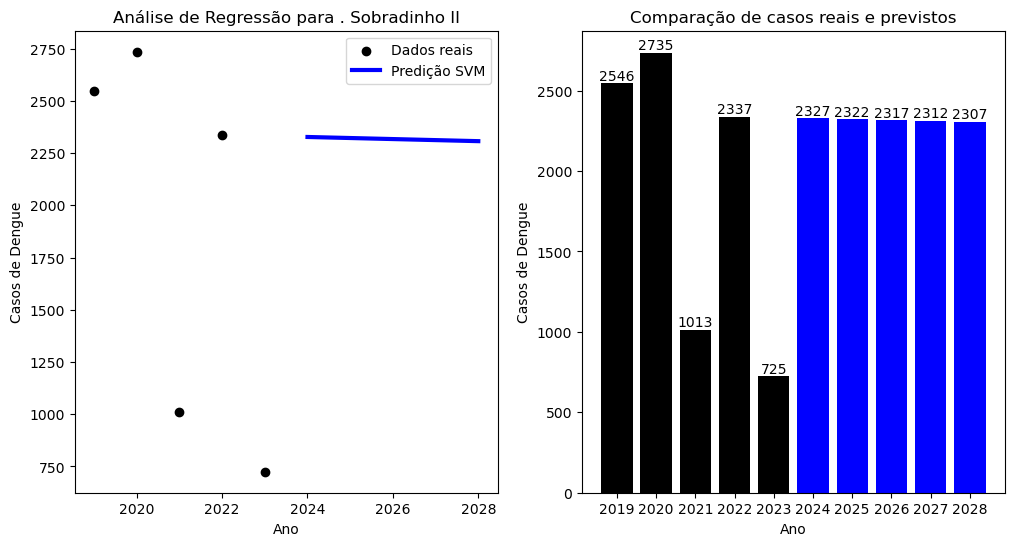

Previsões para os próximos 5 anos para . Brazlândia:
Ano: 2024  - Casos previstos: 1330.0
Ano: 2025  - Casos previstos: 1334.0
Ano: 2026  - Casos previstos: 1338.0
Ano: 2027  - Casos previstos: 1342.0
Ano: 2028  - Casos previstos: 1346.0


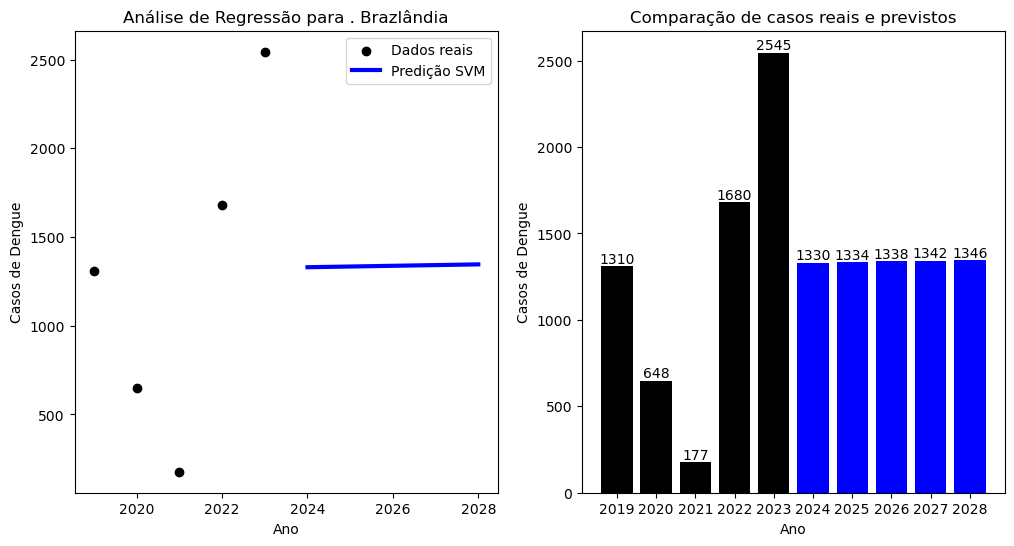

Previsões para os próximos 5 anos para . Ceilândia:
Ano: 2024  - Casos previstos: 5269.0
Ano: 2025  - Casos previstos: 5274.0
Ano: 2026  - Casos previstos: 5279.0
Ano: 2027  - Casos previstos: 5284.0
Ano: 2028  - Casos previstos: 5289.0


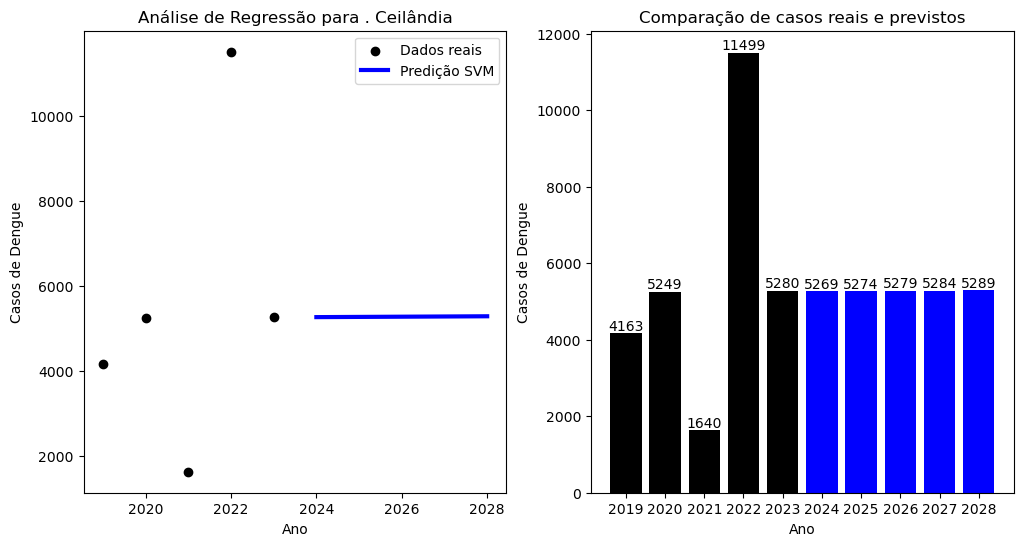

Previsões para os próximos 5 anos para . Águas Claras:
Ano: 2024  - Casos previstos: 852.0
Ano: 2025  - Casos previstos: 850.0
Ano: 2026  - Casos previstos: 848.0
Ano: 2027  - Casos previstos: 846.0
Ano: 2028  - Casos previstos: 844.0


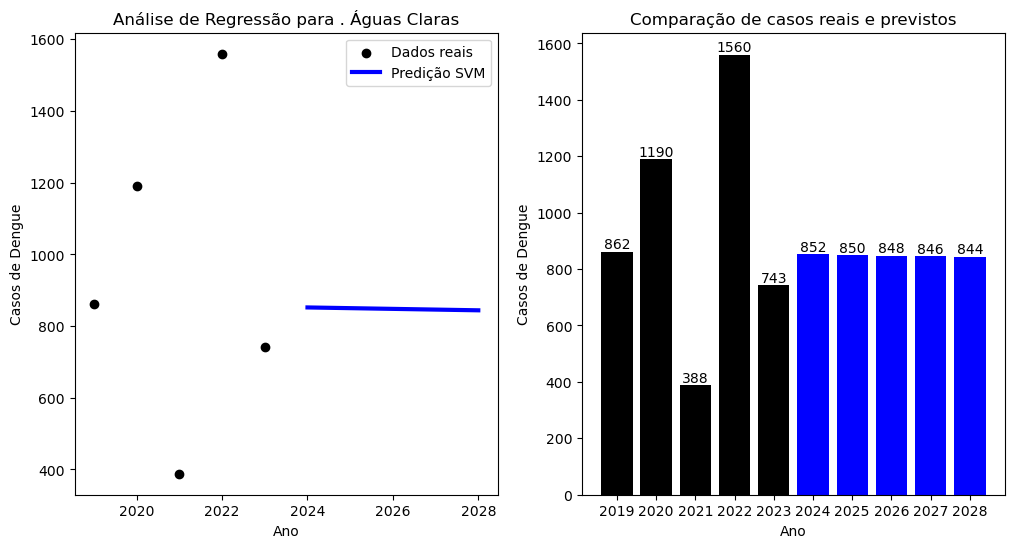

Previsões para os próximos 5 anos para . Recanto Das Emas:
Ano: 2024  - Casos previstos: 2015.0
Ano: 2025  - Casos previstos: 2019.0
Ano: 2026  - Casos previstos: 2023.0
Ano: 2027  - Casos previstos: 2027.0
Ano: 2028  - Casos previstos: 2031.0


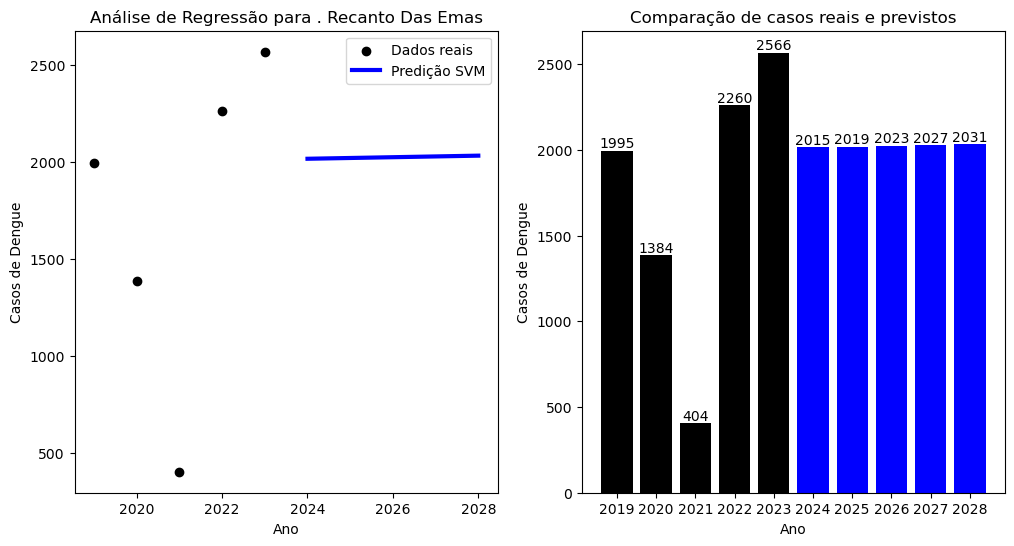

Previsões para os próximos 5 anos para . Samambaia:
Ano: 2024  - Casos previstos: 3442.0
Ano: 2025  - Casos previstos: 3447.0
Ano: 2026  - Casos previstos: 3452.0
Ano: 2027  - Casos previstos: 3457.0
Ano: 2028  - Casos previstos: 3462.0


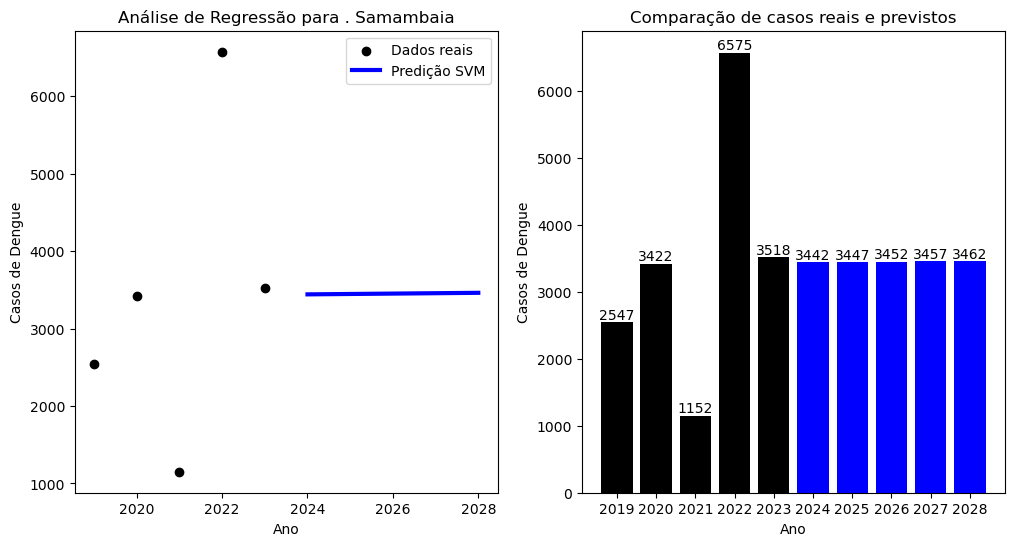

Previsões para os próximos 5 anos para . Taguatinga:
Ano: 2024  - Casos previstos: 2171.0
Ano: 2025  - Casos previstos: 2173.0
Ano: 2026  - Casos previstos: 2175.0
Ano: 2027  - Casos previstos: 2177.0
Ano: 2028  - Casos previstos: 2179.0


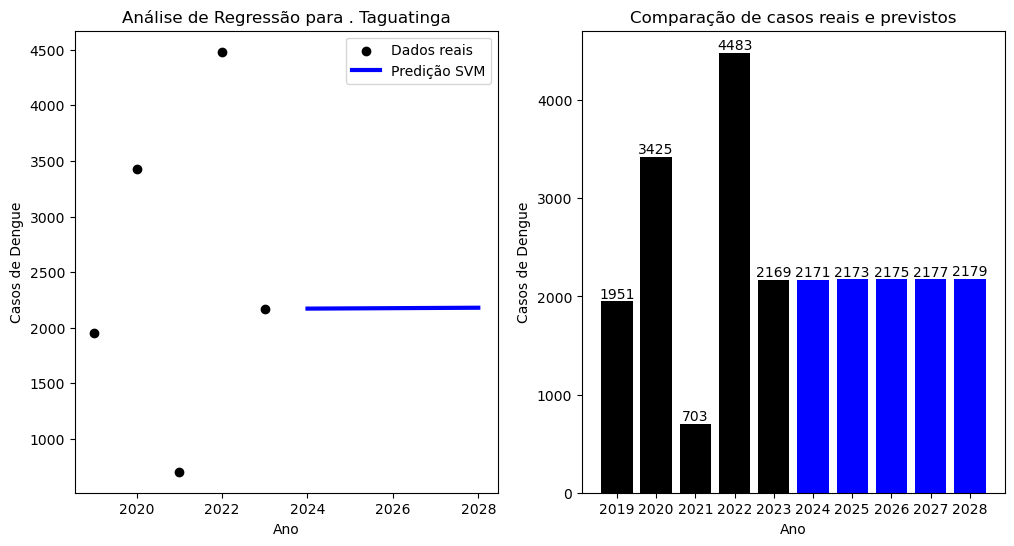

Previsões para os próximos 5 anos para . Vicente Pires:
Ano: 2024  - Casos previstos: 1101.0
Ano: 2025  - Casos previstos: 1103.0
Ano: 2026  - Casos previstos: 1105.0
Ano: 2027  - Casos previstos: 1107.0
Ano: 2028  - Casos previstos: 1109.0


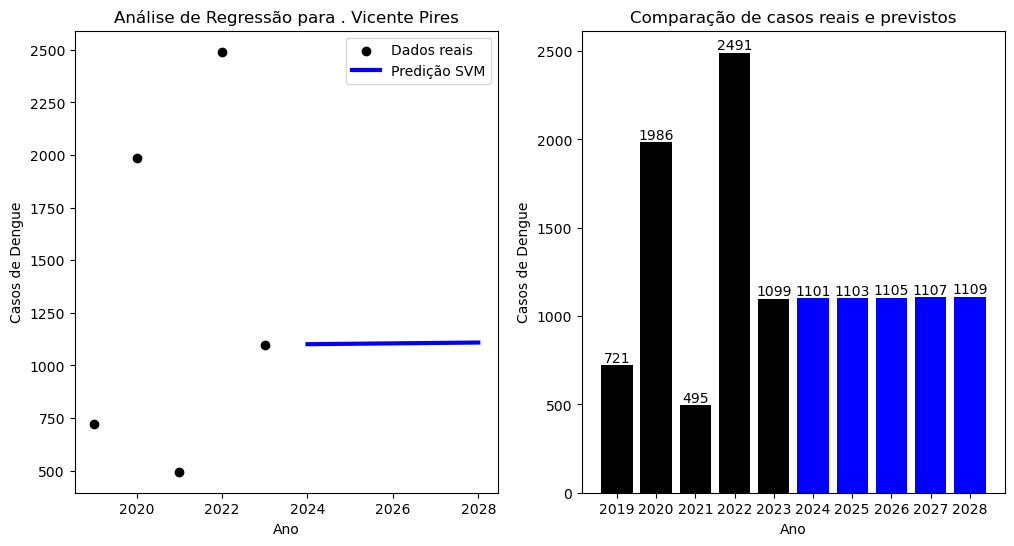

Previsões para os próximos 5 anos para . Gama:
Ano: 2024  - Casos previstos: 935.0
Ano: 2025  - Casos previstos: 937.0
Ano: 2026  - Casos previstos: 939.0
Ano: 2027  - Casos previstos: 941.0
Ano: 2028  - Casos previstos: 943.0


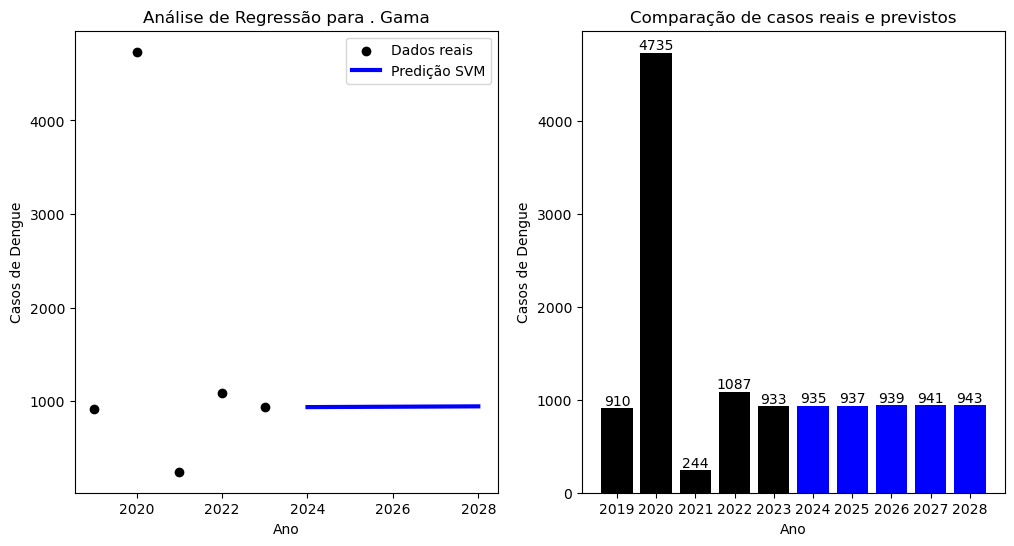

Previsões para os próximos 5 anos para . Santa Maria:
Ano: 2024  - Casos previstos: 730.0
Ano: 2025  - Casos previstos: 725.0
Ano: 2026  - Casos previstos: 720.0
Ano: 2027  - Casos previstos: 715.0
Ano: 2028  - Casos previstos: 710.0


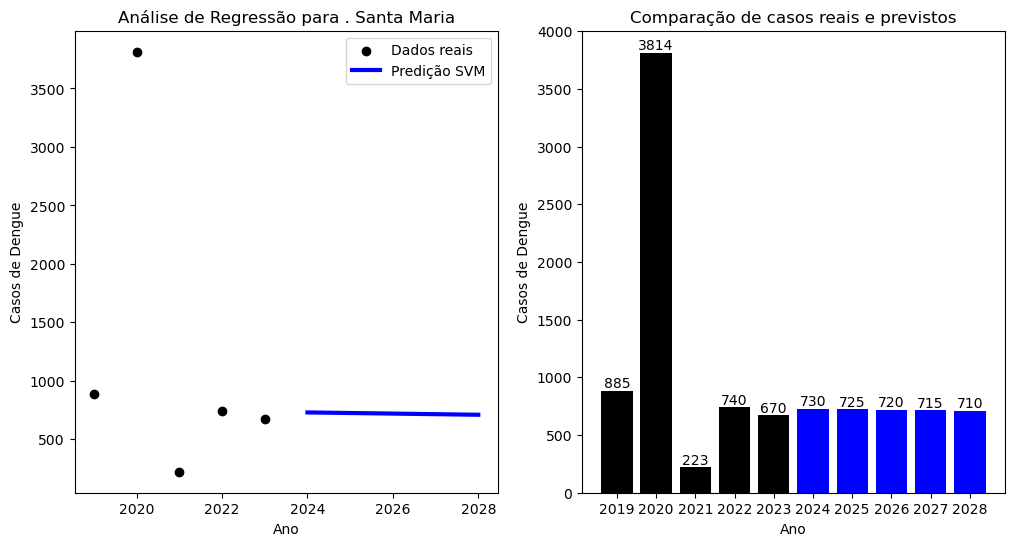

Previsões para os próximos 5 anos para Em Branco:
Ano: 2024  - Casos previstos: 1341.0
Ano: 2025  - Casos previstos: 1345.0
Ano: 2026  - Casos previstos: 1349.0
Ano: 2027  - Casos previstos: 1353.0
Ano: 2028  - Casos previstos: 1357.0


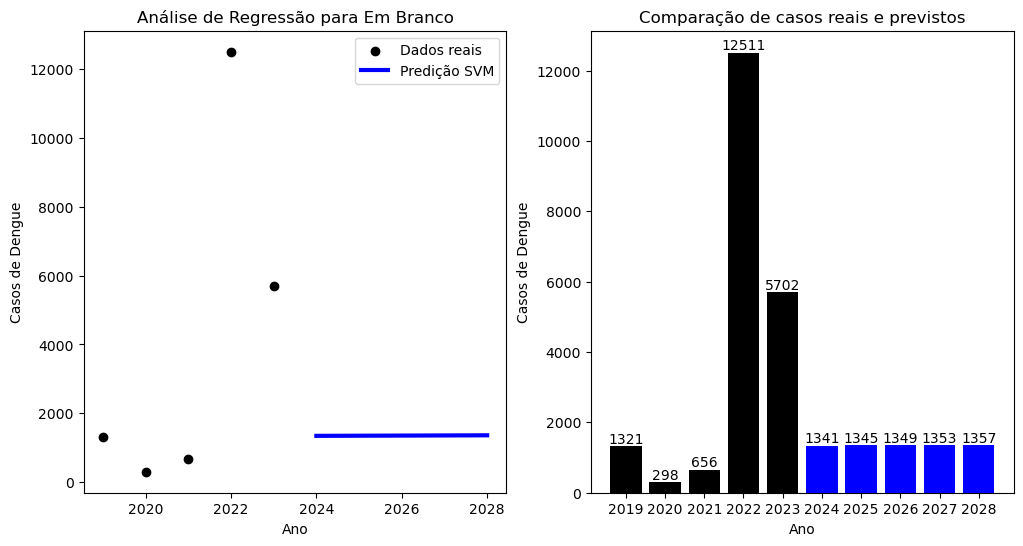

In [95]:
analise_com_svm(linhas_cidades)